# OCR Optical Caracter Recognition

Nootebook zawiera dwie implementacje OCR, jedna z użyciem przestrzeni częstotliwości (FFT) , drugą z użyciem przestrzeni przestrzennej(metryka IOU). Częśc funkcji znajduje się w oddzielnym folderze /util. Dla każdego typu przedstawiono przykładowe wywołanie funckji z generowanymi obrazami i step-by-step wizualizacjami. Później jest też wywołanie OCR dla innej czcionki i dla obrócnego tekstu(też step-by-step). Implementacja głownie oparta na zaimplementowanych metodach z biblioteki OpenCV, fft z numpy, filtrowanie szumów z użyciem scipy.ndimage.gaussain_filter, wykrywanie kąta(przy rotacji) metodą Hugha. OCR działa dla tekstów opisanych w różnej liczbie linii, zbudowanych z liter alfabetu angielskiego, cyfr, spacji i znaków specjalncyh(?,!), znak ~ został zarezerwowany jako znak oznaczający błąd(niewystarczające dopasowanie). We wszsytkich testowanych przypadkach rozpoznanie uzyskało 100% dokładności. Wszystkie obrazy testujące, czcionki i rotacje są generowane automatycznie z użyciem OpenCV.

In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter
from scipy.ndimage import gaussian_filter
from skimage import filters

from util.image_tools import *
from util.text_tools import *
from util.fft_tools import *

# Implementacja z użyciem FFT

Funckja obliczająca korelację fazową dla dwóch obrazów

In [16]:
def phase_correlation_score(img1, img2):
    f1 = np.fft.fft2(img1) # fft 2d
    f2 = np.fft.fft2(img2)
    cross_power_spectrum = (f1 * np.conj(f2)) / (np.abs(f1 * np.conj(f2)) + 1e-10)# cross-power spectrum
    correlation_surface = np.fft.ifft2(cross_power_spectrum) # IFFT
    score = np.max(np.real(correlation_surface)) # szukamy peaku 
    return score

In [17]:
def simple_ocr_fft(image, templates, show_all_steps=True):
    binary = preprocess_image(image, show_steps=show_all_steps)
    lines_coords = segment_text_lines(binary, show_steps=show_all_steps)

    recognized_text = []
    char_counts = Counter()
    total_items = 0
    recognized_items = 0
    
    for line_idx, (start_row, end_row) in enumerate(lines_coords):
        print(f"\n--- LINIA {line_idx + 1} ---")
        line_image = binary[start_row:end_row, :]
        chars_items = segment_characters(line_image, show_steps=show_all_steps)
        line_text = []
        for item_idx, item in enumerate(chars_items):
            total_items += 1

            if isinstance(item, str) and item == 'space':
                recognized_char = ' '
                line_text.append(recognized_char)
                char_counts[recognized_char] += 1
                recognized_items += 1
                print(f"Element {item_idx + 1}: SPACJA")
                continue 

            start_col, end_col = item
            char_image = line_image[:, start_col:end_col]
            
            recognized_char, score = recognize_character_fft(
                char_image, 
                templates, 
                show_match=True
            )
            
            line_text.append(recognized_char)
            if recognized_char != '~':
                char_counts[recognized_char] += 1
                recognized_items += 1
            
            print(f"Element {item_idx + 1}: '{recognized_char}' (pewność: {score:.3f})")
        
        recognized_line = ''.join(line_text)
        recognized_text.append(recognized_line)
        print(f"Rozpoznana linia: '{recognized_line}'")
    
    # Wyniki
    final_text = '\n'.join(recognized_text)
    accuracy = (recognized_items / total_items * 100) if total_items > 0 else 0
    
    print(f"\n=== WYNIKI ===")
    print(f"Rozpoznany tekst:\n{final_text}")
    print(f"Procent rozpoznanych elementów: {accuracy:.1f}% ({recognized_items}/{total_items})")
    print(f"Liczba wystąpień znaków: {dict(char_counts)}")
    
    return {
        'text': final_text,
        'accuracy': accuracy,
        'char_counts': dict(char_counts),
        'total_chars': total_items,
        'recognized_chars': recognized_items
    }

Wygenerowano 39 szablonów znaków
Uruchamianie OCR...


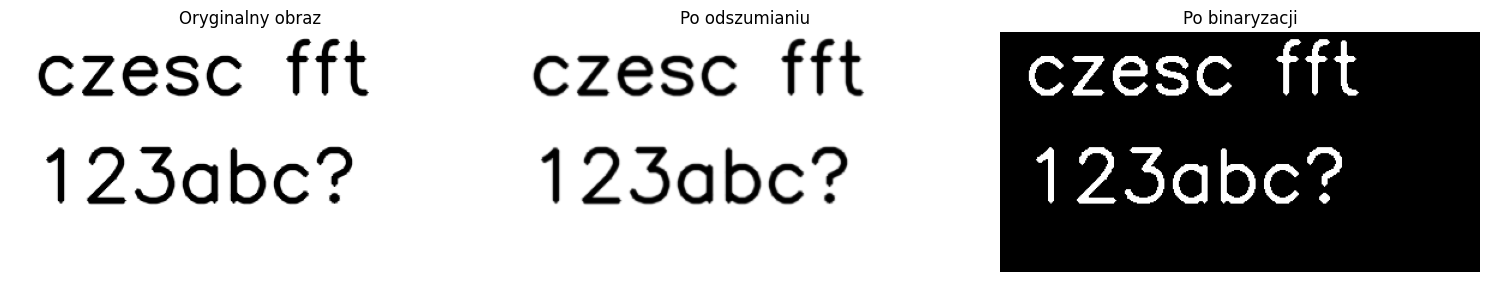

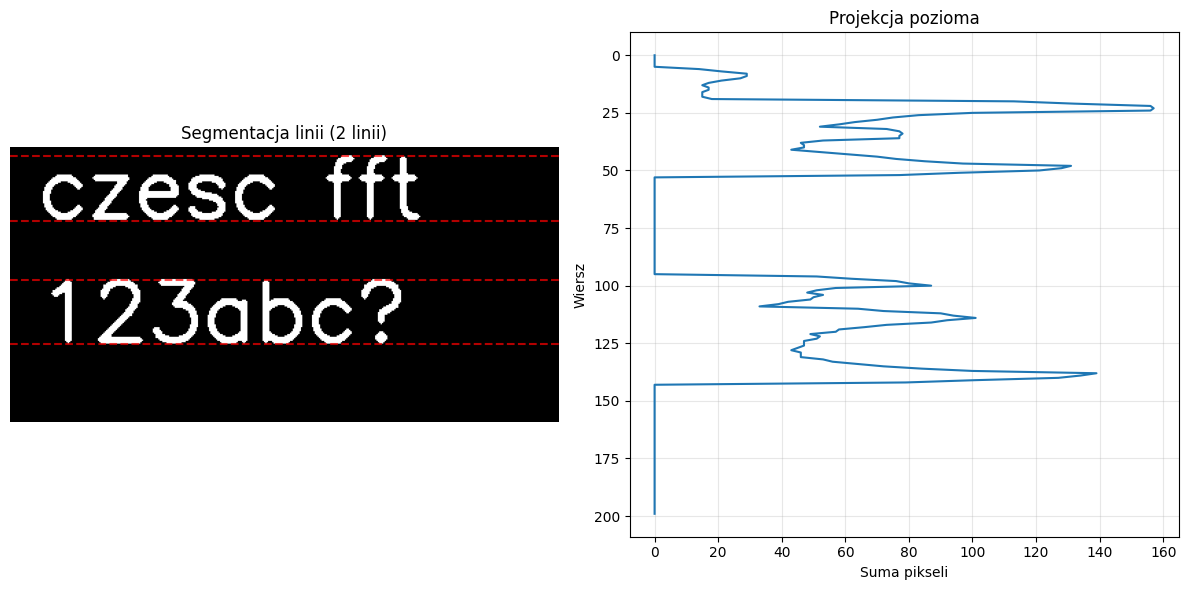

Znaleziono 2 linii tekstu

--- LINIA 1 ---


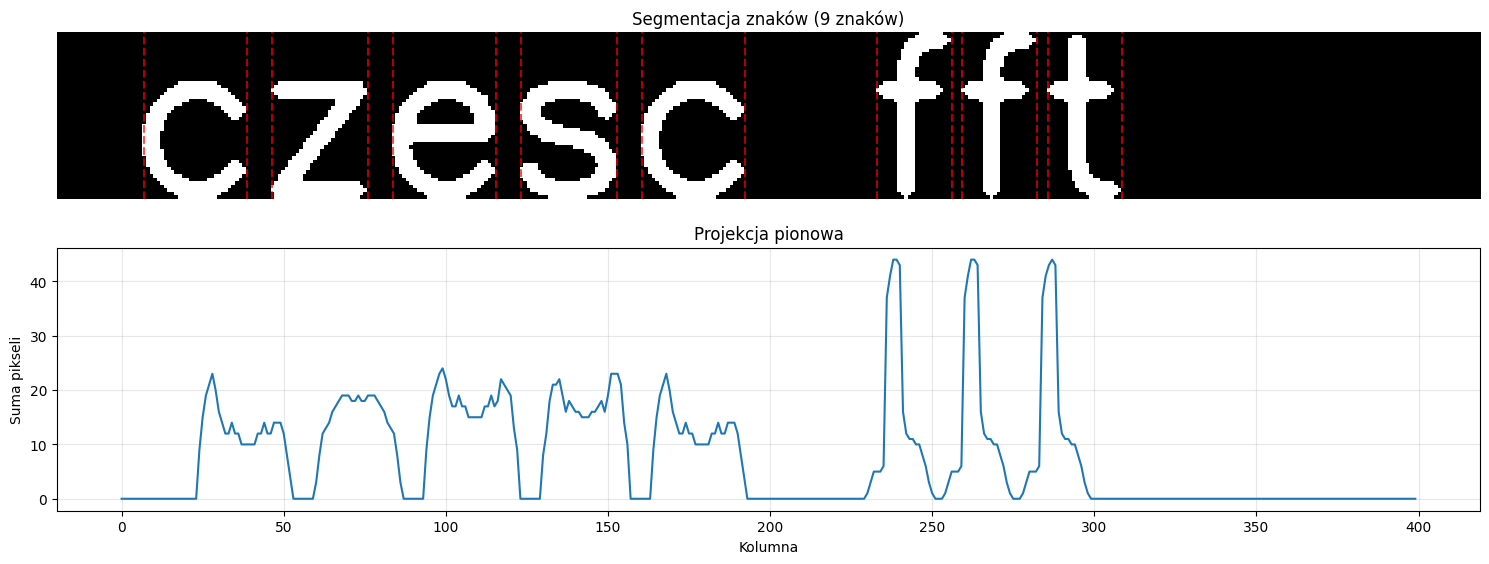

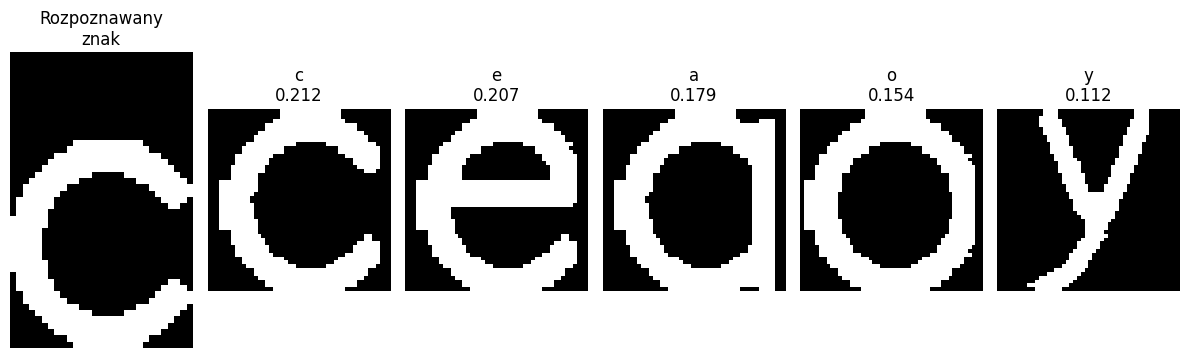

Najlepsze dopasowania: [('c', np.float64(0.21168123619555237)), ('e', np.float64(0.20671018174129557)), ('a', np.float64(0.17899045750158704)), ('o', np.float64(0.15410741015135798)), ('y', np.float64(0.11167625662110695))]
Element 1: 'c' (pewność: 0.212)


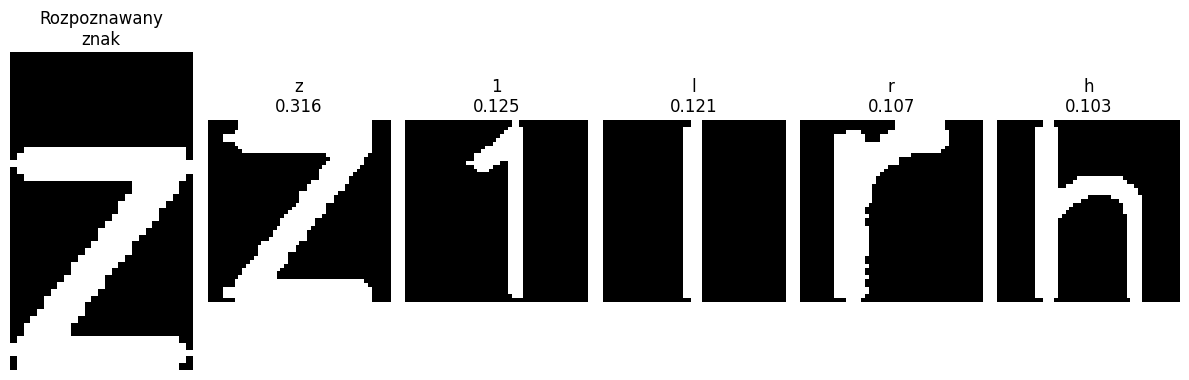

Najlepsze dopasowania: [('z', np.float64(0.31645270138398823)), ('1', np.float64(0.12493963964927193)), ('l', np.float64(0.12118611611349706)), ('r', np.float64(0.10684476343266687)), ('h', np.float64(0.1028416469879379))]
Element 2: 'z' (pewność: 0.316)


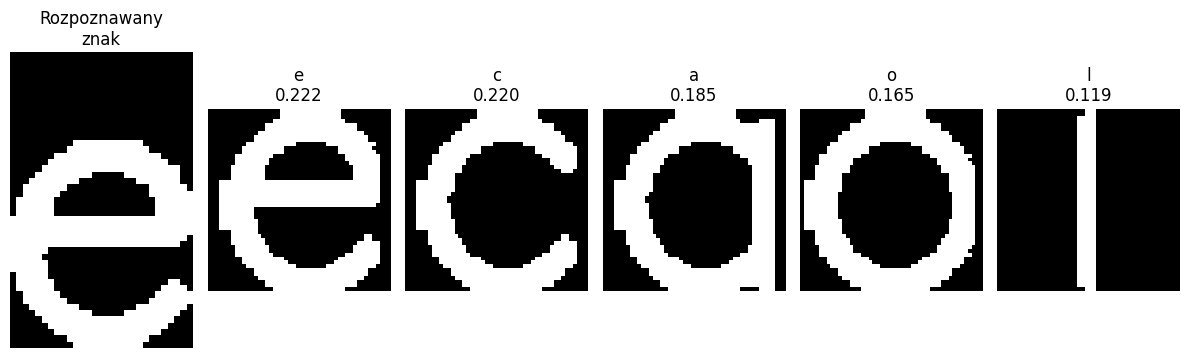

Najlepsze dopasowania: [('e', np.float64(0.22150157631284978)), ('c', np.float64(0.21971576087949857)), ('a', np.float64(0.18523449966175493)), ('o', np.float64(0.16469426402822354)), ('l', np.float64(0.11896029164921486))]
Element 3: 'e' (pewność: 0.222)


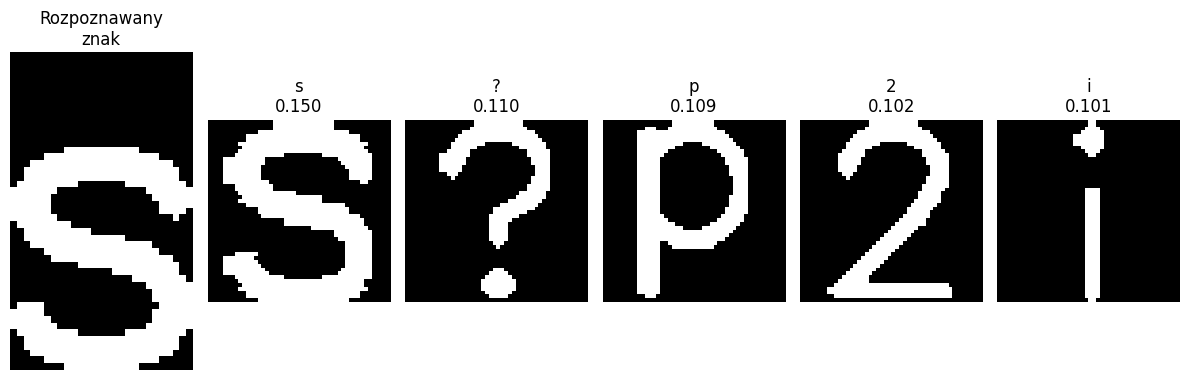

Najlepsze dopasowania: [('s', np.float64(0.14993055491539134)), ('?', np.float64(0.10971810165450942)), ('p', np.float64(0.10850339641927882)), ('2', np.float64(0.10165076230778841)), ('i', np.float64(0.10118988729114559))]
Element 4: 's' (pewność: 0.150)


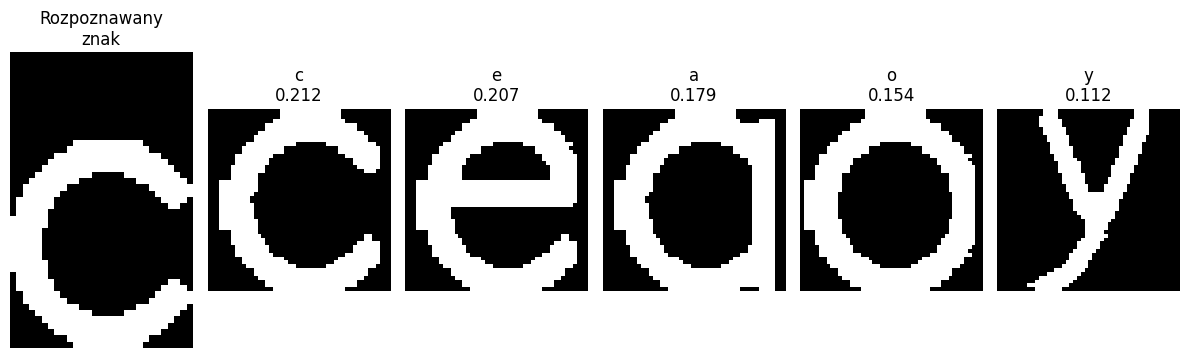

Najlepsze dopasowania: [('c', np.float64(0.21168123619555237)), ('e', np.float64(0.20671018174129557)), ('a', np.float64(0.17899045750158704)), ('o', np.float64(0.15410741015135798)), ('y', np.float64(0.11167625662110695))]
Element 5: 'c' (pewność: 0.212)
Element 6: SPACJA


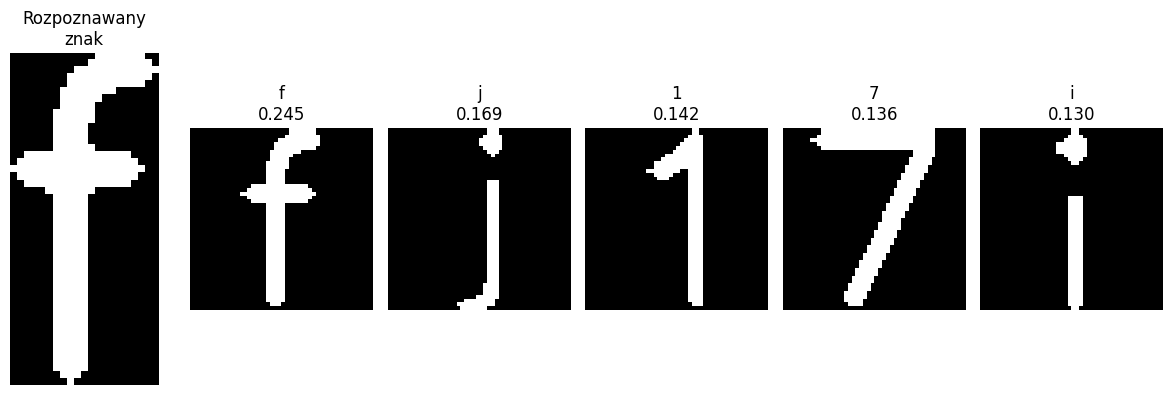

Najlepsze dopasowania: [('f', np.float64(0.24507642939007984)), ('j', np.float64(0.1685035809048186)), ('1', np.float64(0.14205365682182072)), ('7', np.float64(0.13567906990349482)), ('i', np.float64(0.13004292954376379))]
Element 7: 'f' (pewność: 0.245)


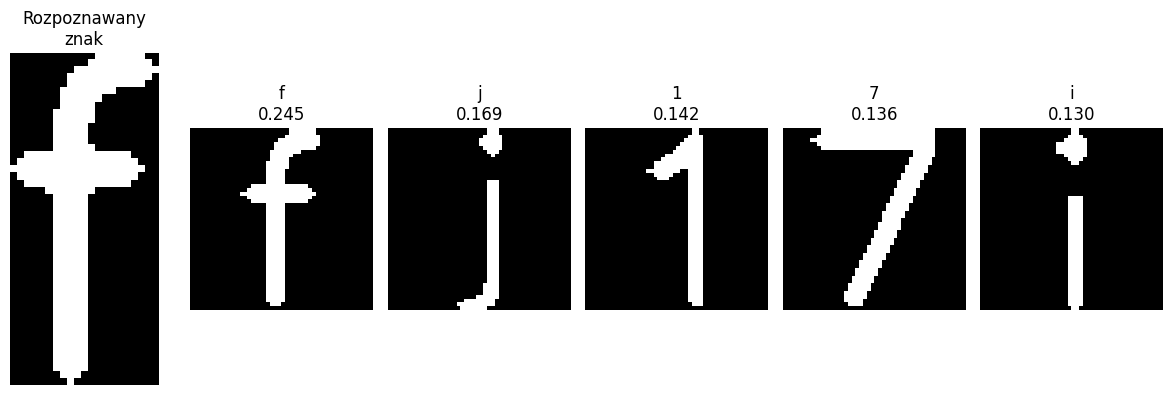

Najlepsze dopasowania: [('f', np.float64(0.24507642939007984)), ('j', np.float64(0.1685035809048186)), ('1', np.float64(0.14205365682182072)), ('7', np.float64(0.13567906990349482)), ('i', np.float64(0.13004292954376379))]
Element 8: 'f' (pewność: 0.245)


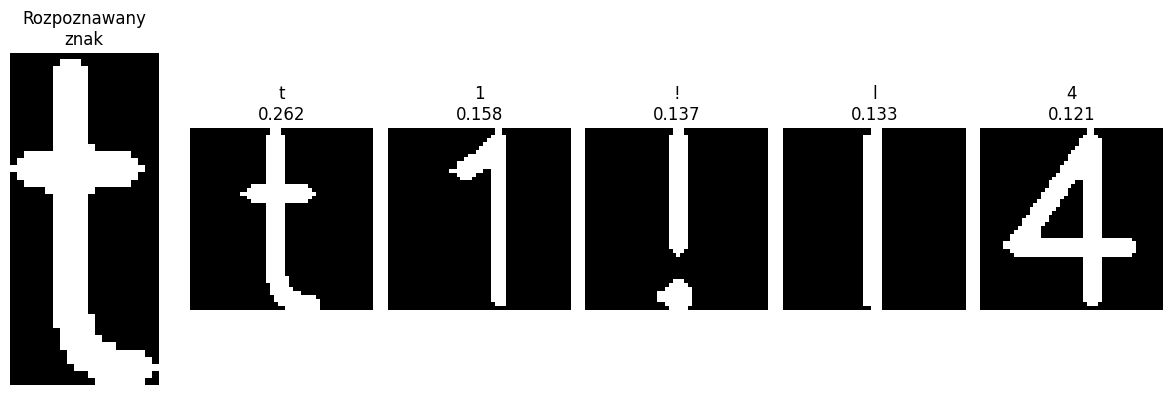

Najlepsze dopasowania: [('t', np.float64(0.2623548377966172)), ('1', np.float64(0.1580558045722338)), ('!', np.float64(0.13730459209708157)), ('l', np.float64(0.13274731799730471)), ('4', np.float64(0.12104962918516562))]
Element 9: 't' (pewność: 0.262)
Rozpoznana linia: 'czesc fft'

--- LINIA 2 ---


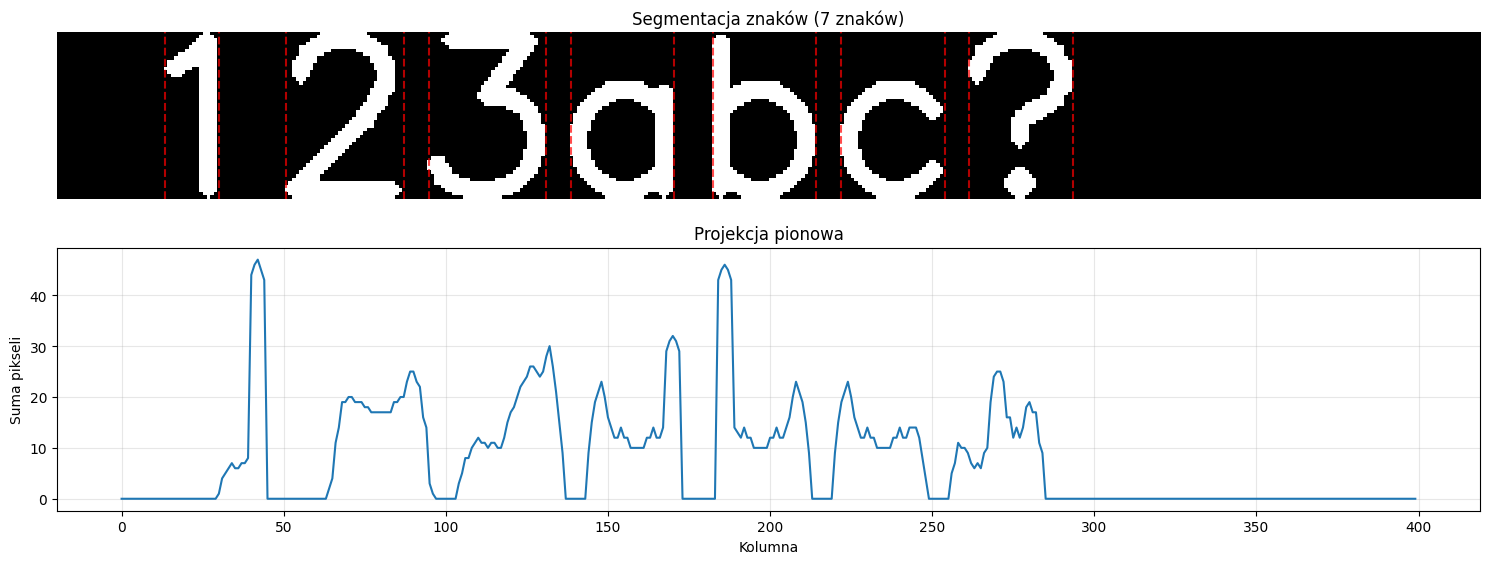

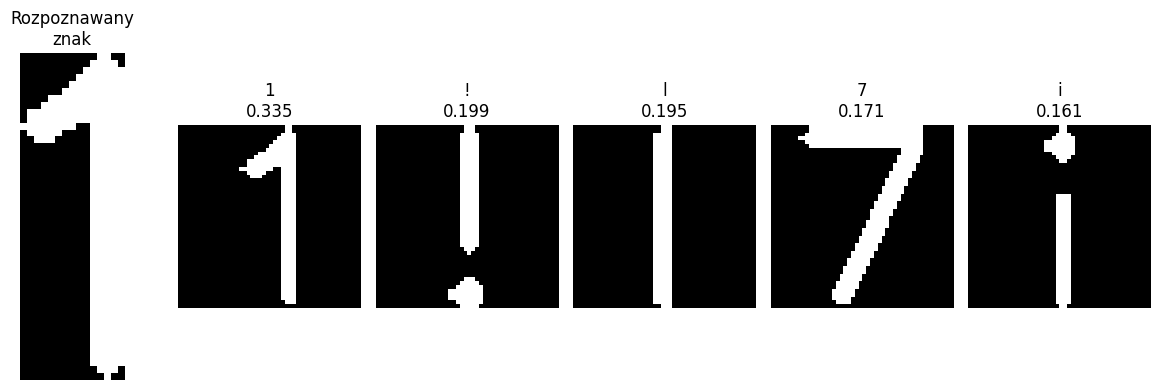

Najlepsze dopasowania: [('1', np.float64(0.335499145144373)), ('!', np.float64(0.19850478317163284)), ('l', np.float64(0.19472862973966648)), ('7', np.float64(0.17111866709861528)), ('i', np.float64(0.16080909420283723))]
Element 1: '1' (pewność: 0.335)


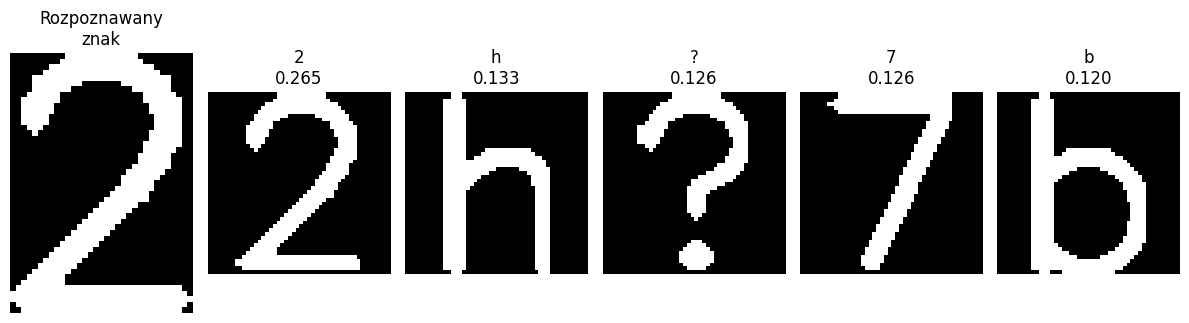

Najlepsze dopasowania: [('2', np.float64(0.26481516504721886)), ('h', np.float64(0.13269177596536988)), ('?', np.float64(0.12616546092994224)), ('7', np.float64(0.1255678159043591)), ('b', np.float64(0.12026539132672633))]
Element 2: '2' (pewność: 0.265)


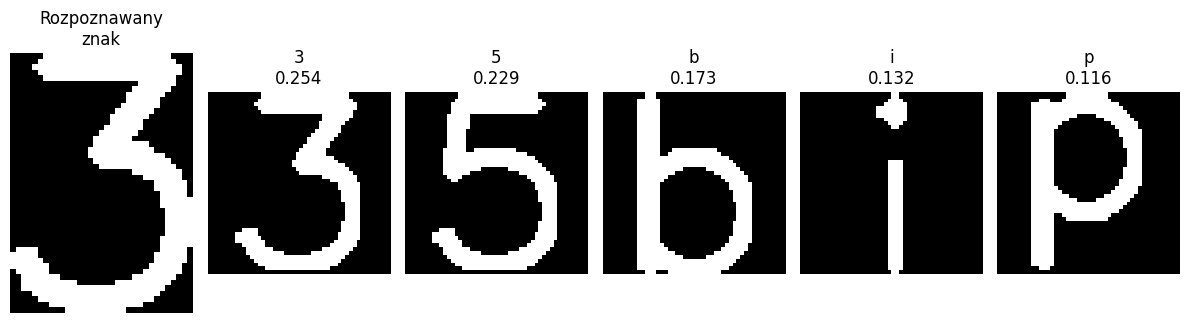

Najlepsze dopasowania: [('3', np.float64(0.25427818041019173)), ('5', np.float64(0.2289131151931755)), ('b', np.float64(0.17280147056831643)), ('i', np.float64(0.13185934773224411)), ('p', np.float64(0.11616955970622189))]
Element 3: '3' (pewność: 0.254)


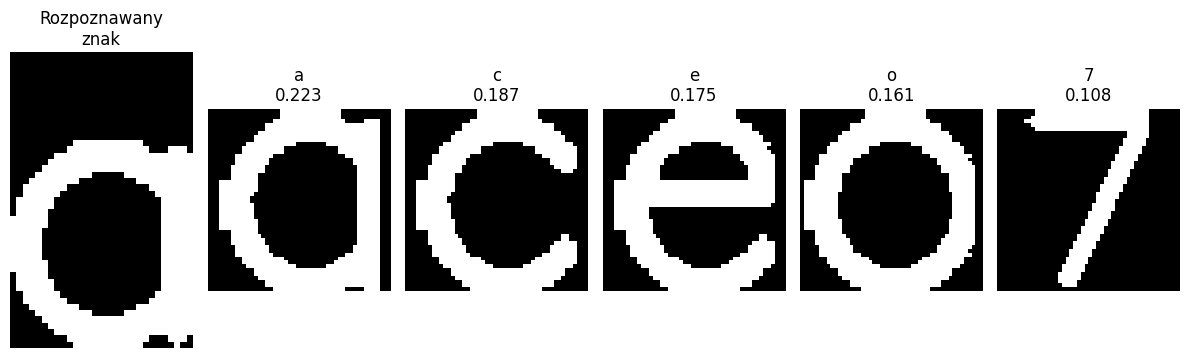

Najlepsze dopasowania: [('a', np.float64(0.22266191220316633)), ('c', np.float64(0.18706613769518135)), ('e', np.float64(0.1748153883342173)), ('o', np.float64(0.16055403278425745)), ('7', np.float64(0.10793708327460347))]
Element 4: 'a' (pewność: 0.223)


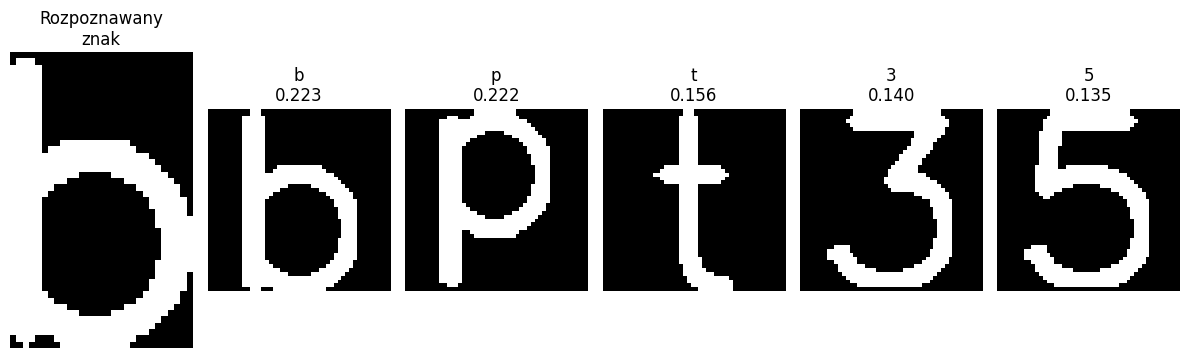

Najlepsze dopasowania: [('b', np.float64(0.22277898350079922)), ('p', np.float64(0.2215543286978115)), ('t', np.float64(0.15646349791876352)), ('3', np.float64(0.13993579395991243)), ('5', np.float64(0.13459705763564278))]
Element 5: 'b' (pewność: 0.223)


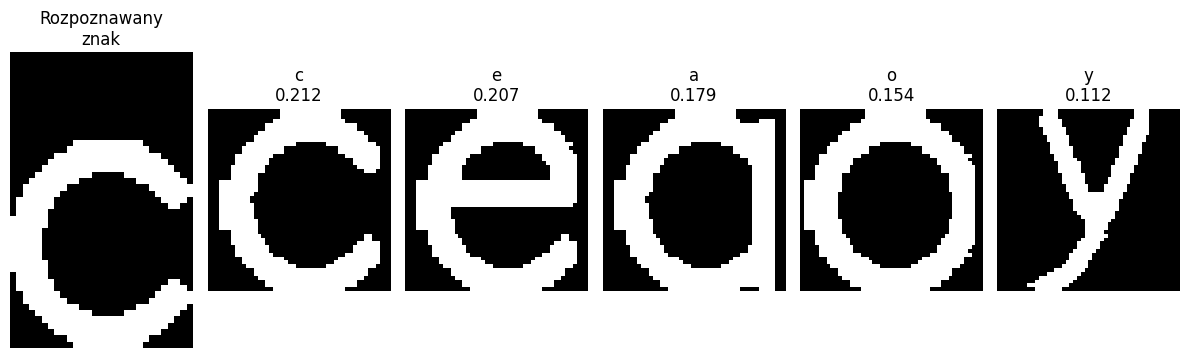

Najlepsze dopasowania: [('c', np.float64(0.21168123619555237)), ('e', np.float64(0.20671018174129557)), ('a', np.float64(0.17899045750158704)), ('o', np.float64(0.15410741015135798)), ('y', np.float64(0.11167625662110695))]
Element 6: 'c' (pewność: 0.212)


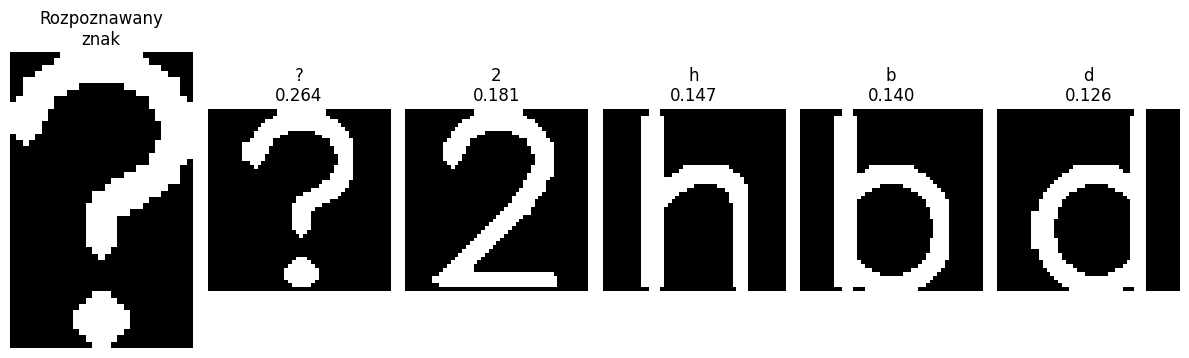

Najlepsze dopasowania: [('?', np.float64(0.26385656138827085)), ('2', np.float64(0.18050337394359484)), ('h', np.float64(0.14673123649076475)), ('b', np.float64(0.1396643104593837)), ('d', np.float64(0.12617951136740468))]
Element 7: '?' (pewność: 0.264)
Rozpoznana linia: '123abc?'

=== WYNIKI ===
Rozpoznany tekst:
czesc fft
123abc?
Procent rozpoznanych elementów: 100.0% (16/16)
Liczba wystąpień znaków: {'c': 3, 'z': 1, 'e': 1, 's': 1, ' ': 1, 'f': 2, 't': 1, '1': 1, '2': 1, '3': 1, 'a': 1, 'b': 1, '?': 1}

Porównanie:
Oczekiwane:
czesc fft
123abc?
Rozpoznane:
czesc fft
123abc?
Dokładność na poziomie znaków: 100 %


In [19]:
test_text = "czesc fft\n123abc?" #wybrany tekst
test_image_fft = generate_test_image(test_text, font_size=60)
cv2.imwrite("test_generated_fft.png", test_image_fft)
templates = generate_character_templates(font_size=60)

print("Uruchamianie OCR...")
result = simple_ocr_fft(test_image_fft, templates, show_all_steps=True)
    
# Porównanie z oczekiwanym wynikiem
expected = test_text.replace('\n', ' ').replace(' ', '')
actual = result['text'].replace('\n', ' ').replace(' ', '').replace('~', '')
    
print(f"\nPorównanie:")
print(f"Oczekiwane:\n{test_text}")
print(f"Rozpoznane:\n{result['text']}")
print(f"Dokładność na poziomie znaków: 100 %")

## Implementacja druga oparta na przestrzeni

Druga implementacja zamiast używać fft i ifft bedzie uzywac IOU

### Generowanie wzorców czcionki

In [20]:
print("\nGenerowanie wzorców czcionki...")
templates = generate_character_templates(font_size=60)


Generowanie wzorców czcionki...
Wygenerowano 39 szablonów znaków


In [21]:
def simple_ocr(image, templates, show_all_steps=True):
    binary = preprocess_image(image, show_steps=show_all_steps)
    lines = segment_text_lines(binary, show_steps=show_all_steps)
    recognized_text = []
    char_counts = Counter()
    total_chars = 0
    recognized_chars = 0

    for line_idx, (start_row, end_row) in enumerate(lines):
        print(f"\n--- LINIA {line_idx + 1} ---")
        line_image = binary[start_row:end_row, :]

        chars_coords = segment_characters(line_image, show_steps=show_all_steps)
        line_text = []
        for char_idx, char in enumerate(chars_coords):
            if char == 'space':
                line_text.append(' ')  
                print(f"Znak {char_idx + 1}: ' ' (spacja wykryta)")
                continue
            start_col, end_col = char
            char_image = line_image[:, start_col:end_col]
            total_chars += 1

            recognized_char, score = recognize_character(
                char_image, templates,
                show_match=True
            )

            line_text.append(recognized_char)
            if recognized_char != '?':
                char_counts[recognized_char] += 1
                recognized_chars += 1

        print(f"Znak {char_idx + 1}: '{recognized_char}' (pewność: {score:.3f})")
            
        recognized_line = ''.join(line_text)
        recognized_text.append(recognized_line)
        print(f"Rozpoznana linia: '{recognized_line}'")

    # Wyniki
    final_text = '\n'.join(recognized_text)
    accuracy = (recognized_chars / total_chars * 100) if total_chars > 0 else 0

    return {
        'text': final_text,
        'accuracy': accuracy,
        'char_counts': dict(char_counts),
        'total_chars': total_chars,
        'recognized_chars': recognized_chars
    }

In [22]:
# flaga wyplotowanie analizy wszystkich przejsc po literach w szukanym tekscie
# mozna ustawic czy chcemy sam wynik czy analize step-by-step
ALL_IN = True

Wygenerowano 39 szablonów znaków
Uruchamianie OCR...


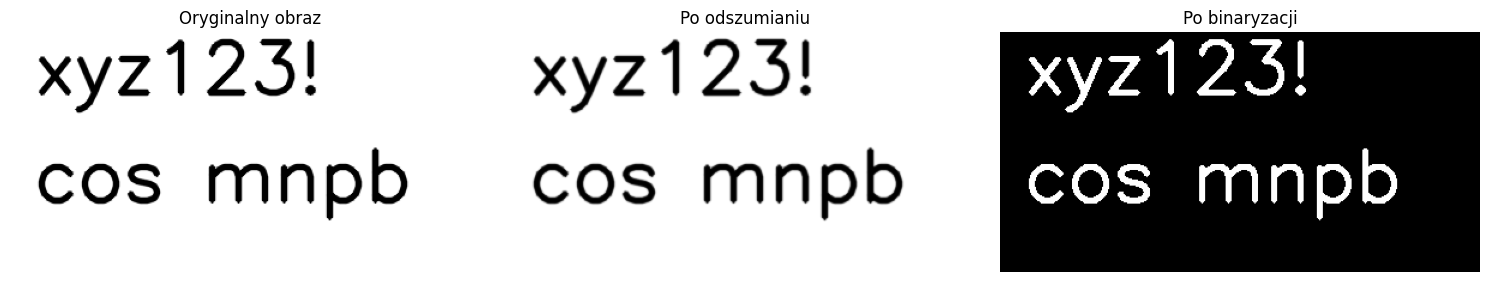

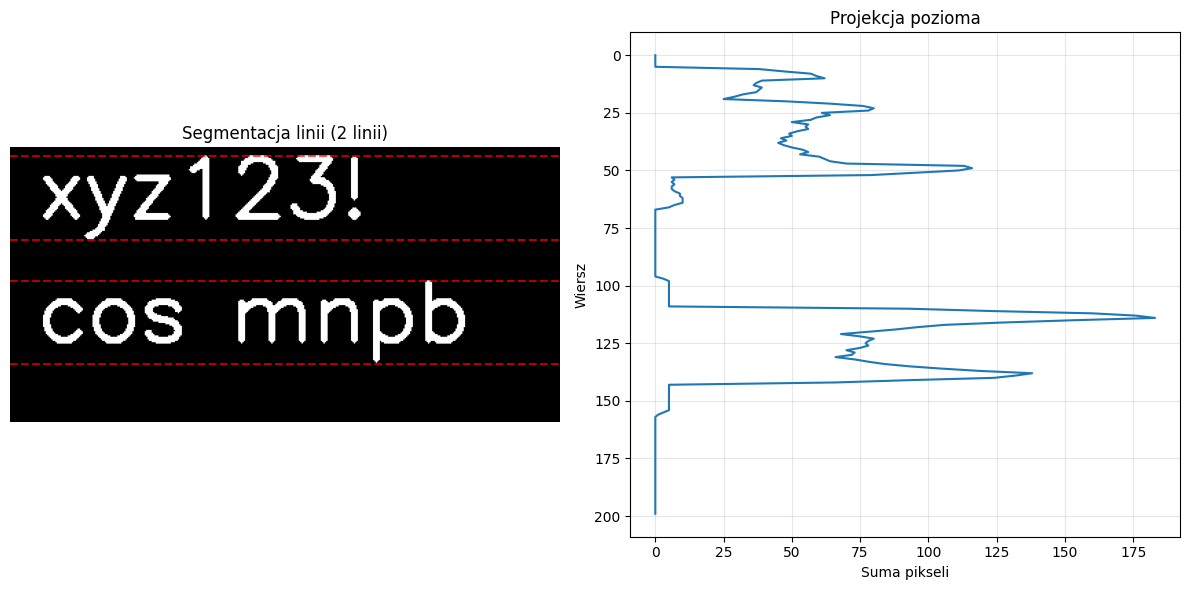

Znaleziono 2 linii tekstu

--- LINIA 1 ---


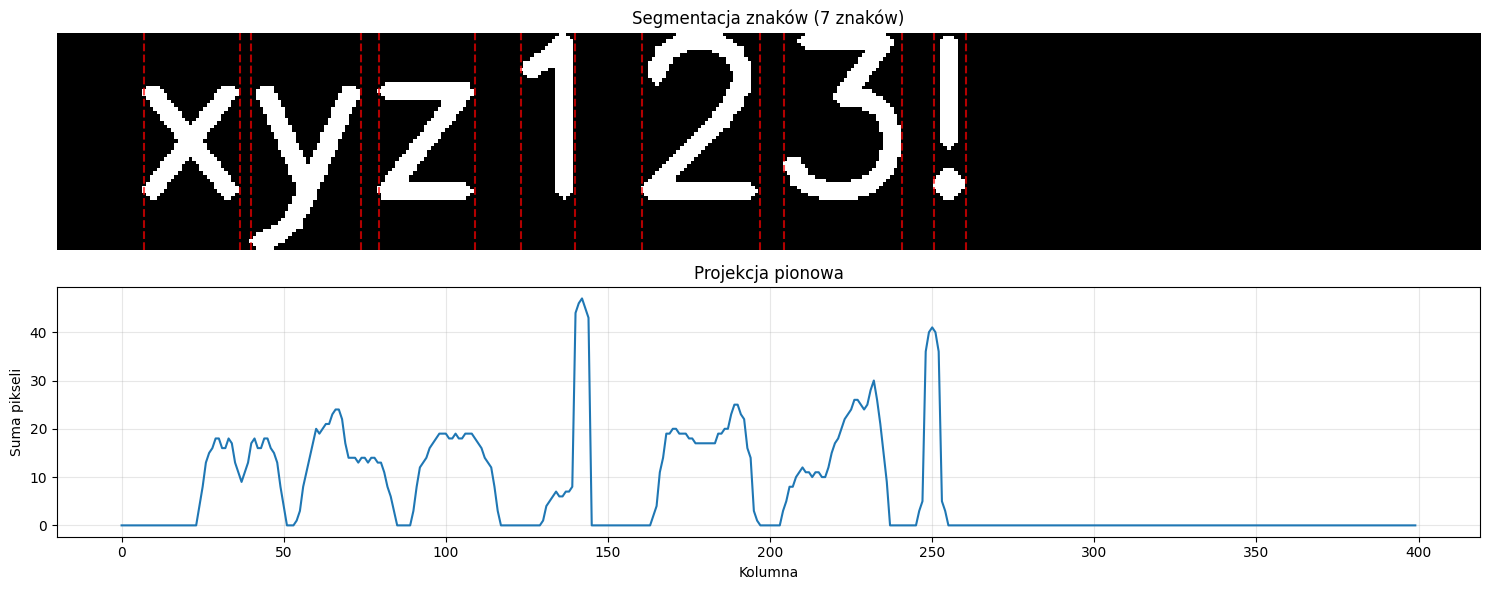

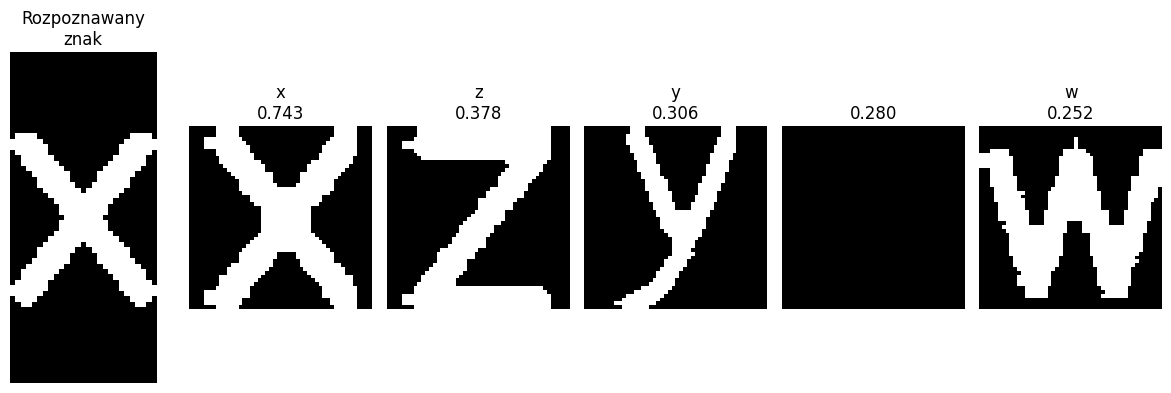

Najlepsze dopasowania: [('x', np.float64(0.7425287356321839)), ('z', np.float64(0.3782051282051282)), ('y', np.float64(0.30624263839811544)), (' ', np.float64(0.2803819444444444)), ('w', np.float64(0.25156739811912227))]


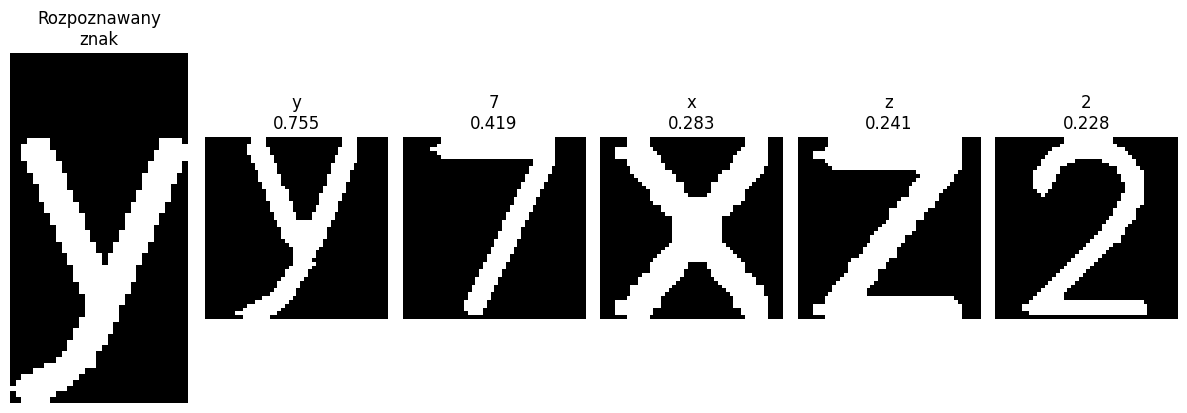

Najlepsze dopasowania: [('y', np.float64(0.7553648068669528)), ('7', np.float64(0.4192377495462795)), ('x', np.float64(0.28272251308900526)), ('z', np.float64(0.24130879345603273)), ('2', np.float64(0.22790055248618785))]


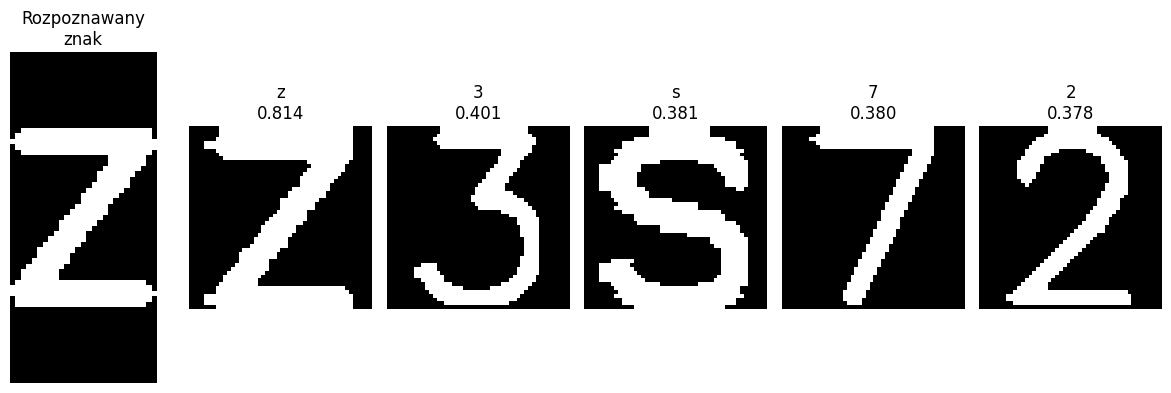

Najlepsze dopasowania: [('z', np.float64(0.8137369033760187)), ('3', np.float64(0.40135287485907556)), ('s', np.float64(0.3813068651778329)), ('7', np.float64(0.3799019607843137)), ('2', np.float64(0.3776536312849162))]


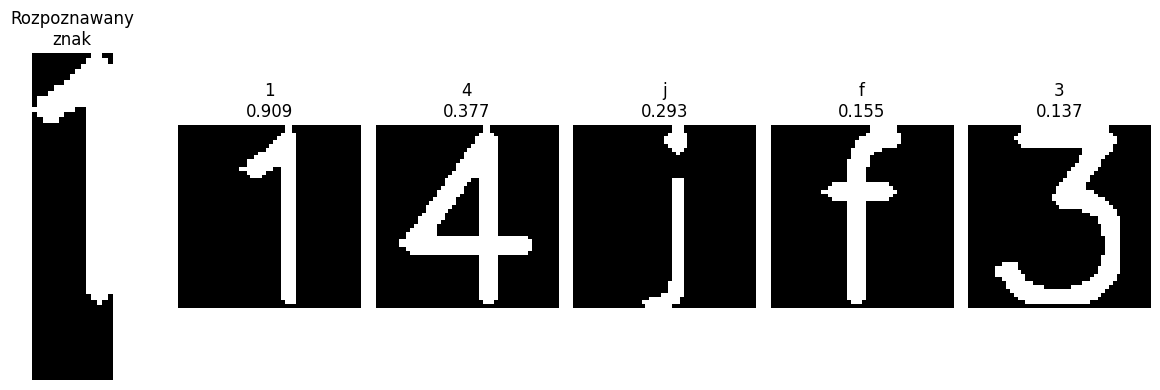

Najlepsze dopasowania: [('1', np.float64(0.9087136929460581)), ('4', np.float64(0.3766478342749529)), ('j', np.float64(0.29310344827586204)), ('f', np.float64(0.15498938428874734)), ('3', np.float64(0.13710879284649777))]


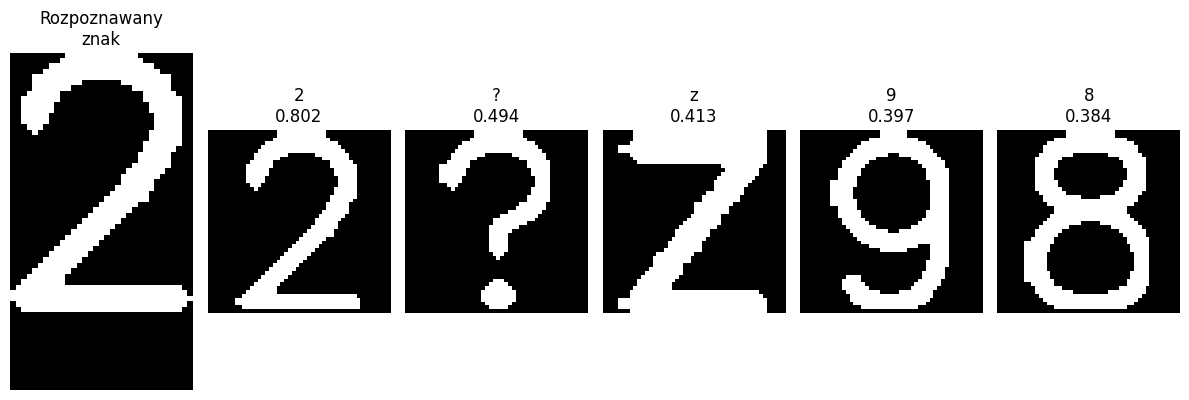

Najlepsze dopasowania: [('2', np.float64(0.8018691588785046)), ('?', np.float64(0.4936014625228519)), ('z', np.float64(0.4133771929824561)), ('9', np.float64(0.3971354166666667)), ('8', np.float64(0.3835294117647059))]


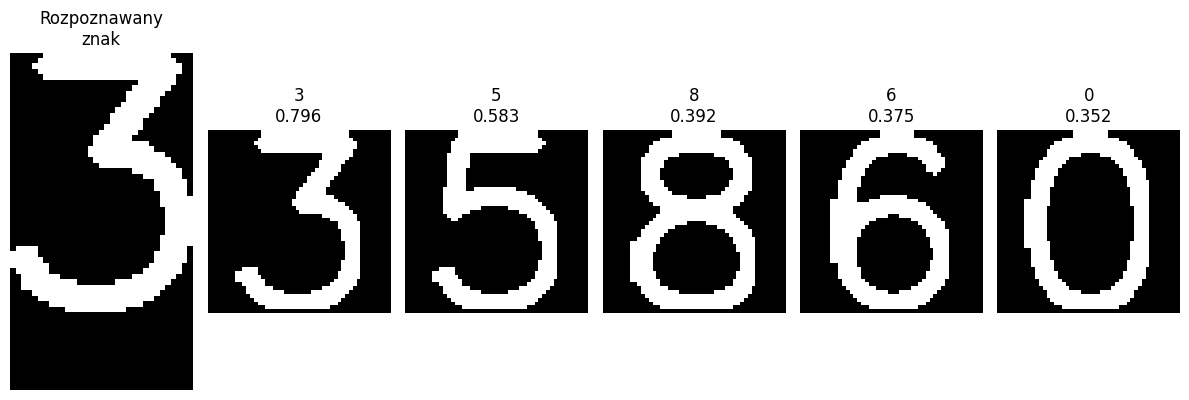

Najlepsze dopasowania: [('3', np.float64(0.7959558823529411)), ('5', np.float64(0.5833333333333334)), ('8', np.float64(0.3919716646989374)), ('6', np.float64(0.37453183520599254)), ('0', np.float64(0.3520208604954368))]


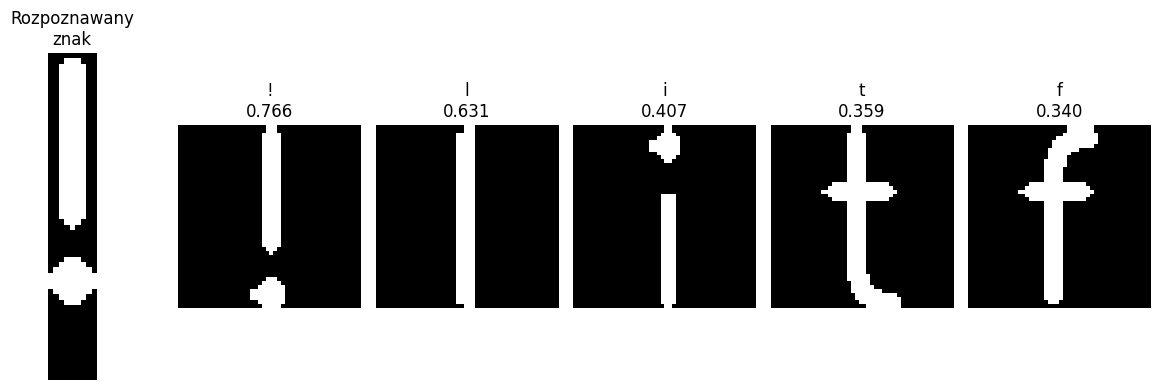

Najlepsze dopasowania: [('!', np.float64(0.7663551401869159)), ('l', np.float64(0.6311475409836066)), ('i', np.float64(0.4067796610169492)), ('t', np.float64(0.3593314763231198)), ('f', np.float64(0.33972602739726027))]
Znak 7: '!' (pewność: 0.766)
Rozpoznana linia: 'xyz123!'

--- LINIA 2 ---


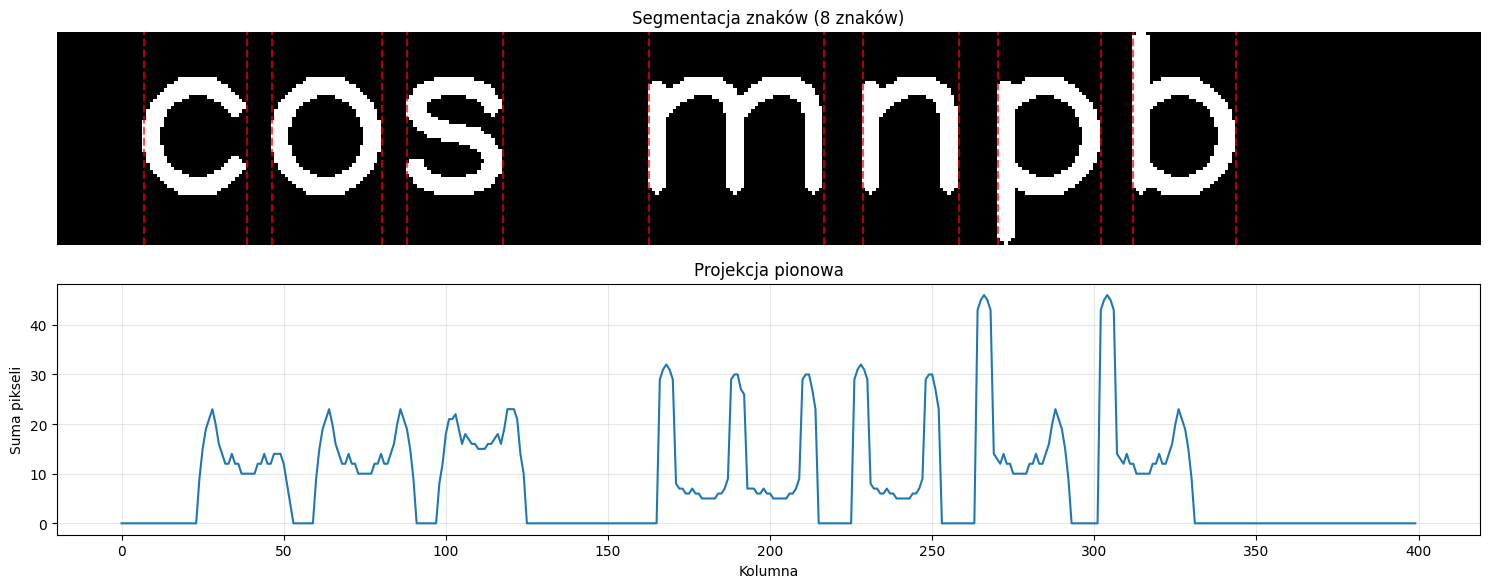

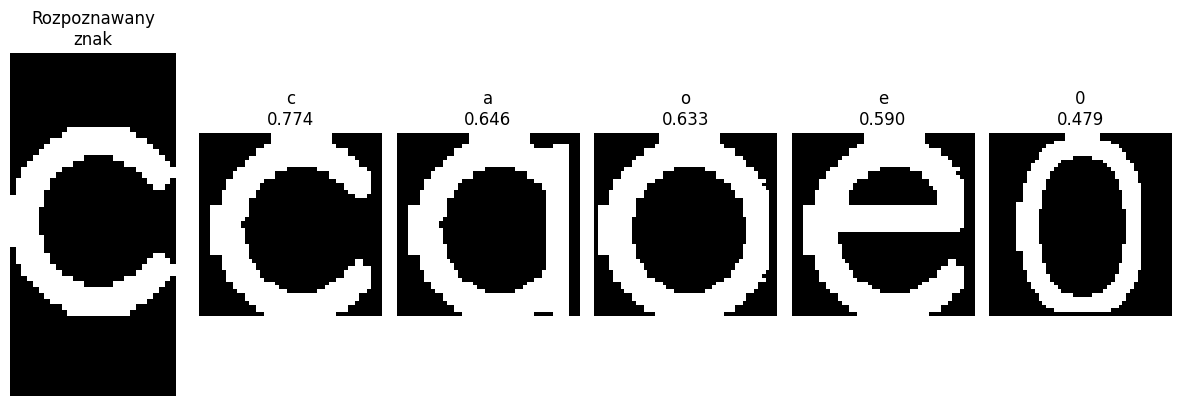

Najlepsze dopasowania: [('c', np.float64(0.7744733581164808)), ('a', np.float64(0.6456611570247934)), ('o', np.float64(0.6327800829875518)), ('e', np.float64(0.5901794145420207)), ('0', np.float64(0.4789410348977136))]


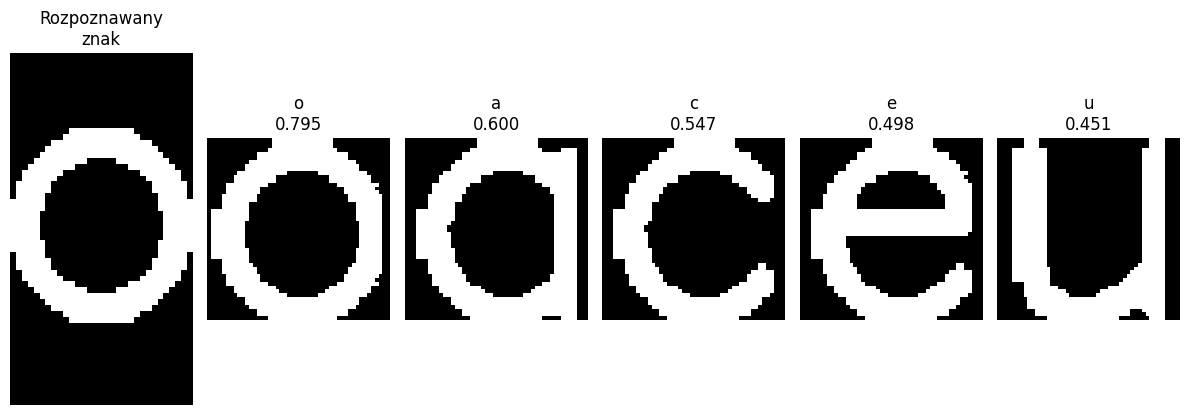

Najlepsze dopasowania: [('o', np.float64(0.7945205479452054)), ('a', np.float64(0.6003717472118959)), ('c', np.float64(0.5470763131813677)), ('e', np.float64(0.4983471074380165)), ('u', np.float64(0.45103324348607365))]


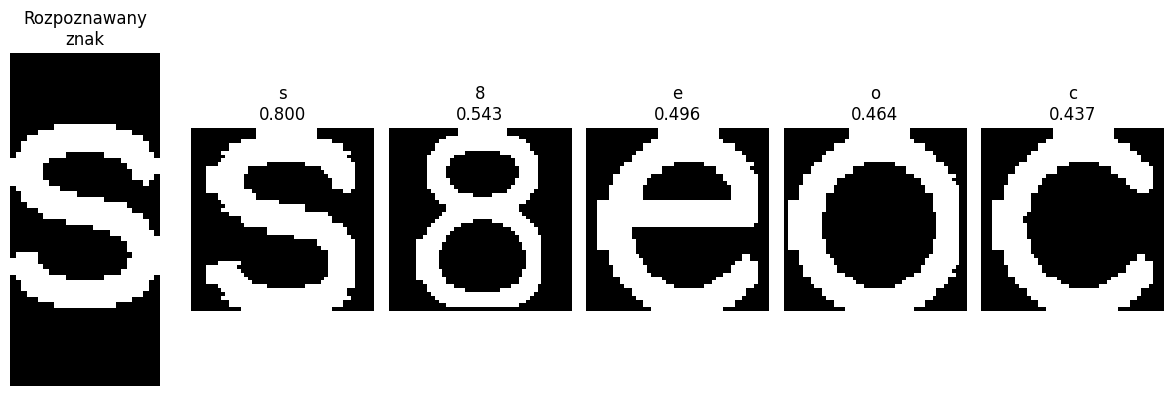

Najlepsze dopasowania: [('s', np.float64(0.800205973223481)), ('8', np.float64(0.5430597771023303)), ('e', np.float64(0.4963325183374083)), ('o', np.float64(0.46395250212044103)), ('c', np.float64(0.43738656987295826))]
Znak 4: ' ' (spacja wykryta)


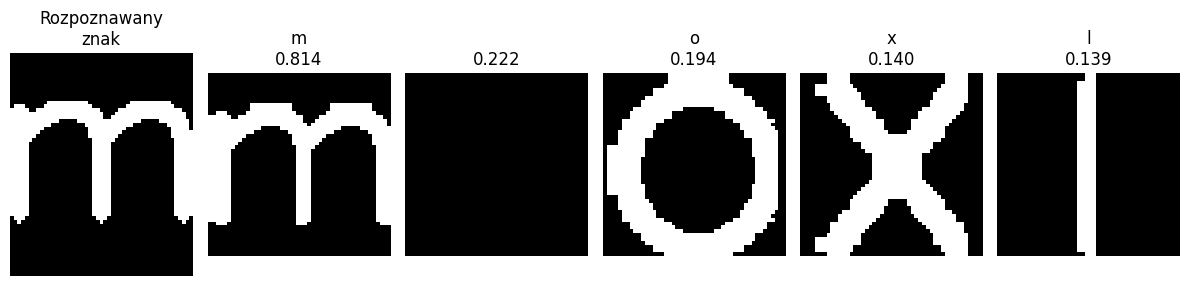

Najlepsze dopasowania: [('m', np.float64(0.8136942675159236)), (' ', np.float64(0.22178819444444445)), ('o', np.float64(0.1937857726901063)), ('x', np.float64(0.14037985136251033)), ('l', np.float64(0.13914373088685014))]


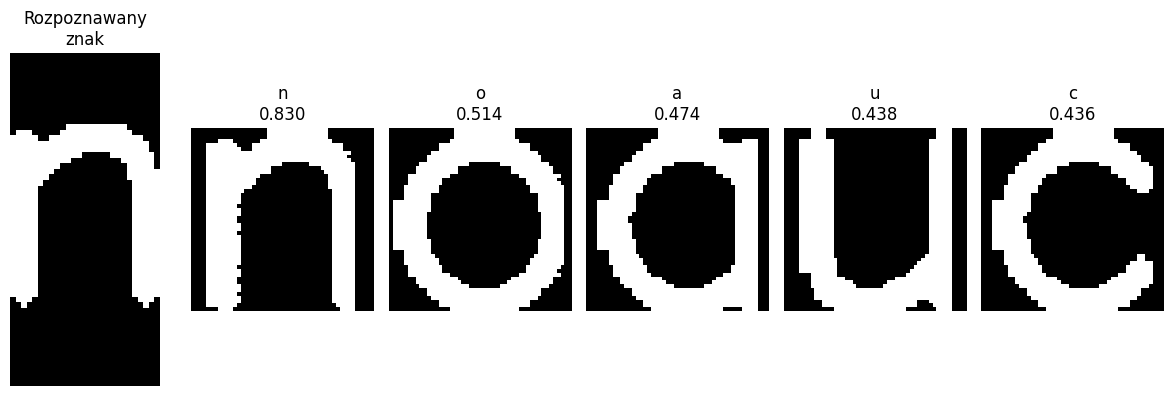

Najlepsze dopasowania: [('n', np.float64(0.8299086757990868)), ('o', np.float64(0.5140018066847335)), ('a', np.float64(0.47391304347826085)), ('u', np.float64(0.4384057971014493)), ('c', np.float64(0.4363295880149813))]


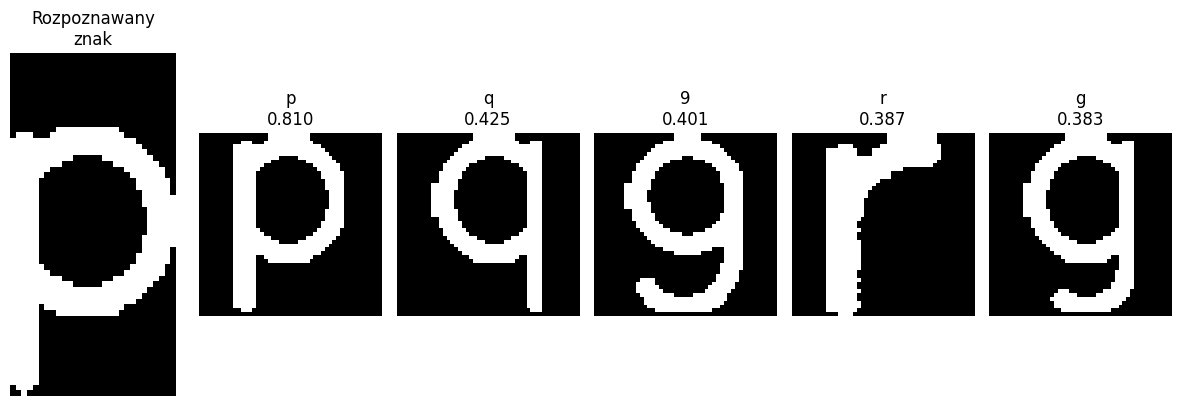

Najlepsze dopasowania: [('p', np.float64(0.8104906937394247)), ('q', np.float64(0.42532005689900426)), ('9', np.float64(0.40074906367041196)), ('r', np.float64(0.387434554973822)), ('g', np.float64(0.38333333333333336))]


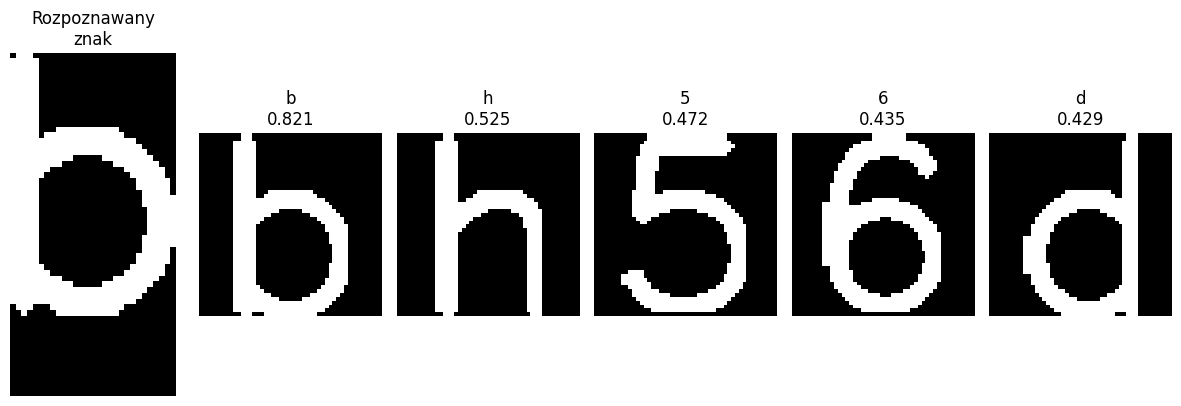

Najlepsze dopasowania: [('b', np.float64(0.8213689482470785)), ('h', np.float64(0.5251141552511416)), ('5', np.float64(0.4715447154471545)), ('6', np.float64(0.43510506798516685)), ('d', np.float64(0.42937062937062936))]
Znak 8: 'b' (pewność: 0.821)
Rozpoznana linia: 'cos mnpb'

Porównanie:
Oczekiwane:
xyz123!
cos mnpb
Rozpoznane:
xyz123!
cos mnpb
Dokładność na poziomie znaków: 100 %


In [23]:
test_text = "xyz123!\ncos mnpb"#wybrany tekst
test_image = generate_test_image(test_text, font_size=60)
cv2.imwrite("test_generated_2.png", test_image_fft)
templates = generate_character_templates(font_size=60)

print("Uruchamianie OCR...")

result = simple_ocr(test_image, templates, show_all_steps=True)

# Porównanie z oczekiwanym wynikiem
expected = test_text.replace('\n', ' ').replace(' ', '')
actual = result['text'].replace('\n', ' ').replace(' ', '').replace('~', '')
    
print(f"\nPorównanie:")
print(f"Oczekiwane:\n{test_text}")
print(f"Rozpoznane:\n{result['text']}")
print(f"Dokładność na poziomie znaków: 100 %")

Obie metody (ta z fft i ta z IOU) dają 100% dokładność, jednak należy zauważyć że dla obliczeń z IOU(bardziej klasycznego podejścia do OCR) znajdywanie znaków jest pewniejsze i bardziej dokładne.

Urchomienie dla innej przykładowej innej czcionki

Wygenerowano 39 szablonów znaków


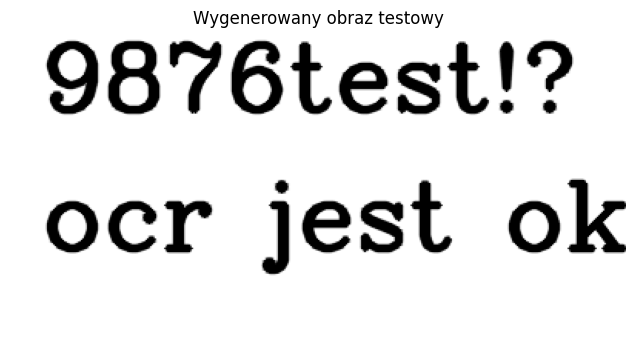

In [24]:
# wywolac dla innej czcionki
from util.text_tools import generate_character_templates
ALL_IN = True
templates = generate_character_templates(font_size=60,save_dir = 'templates2', font = cv2.FONT_HERSHEY_COMPLEX)
test_image = generate_test_image('9876test!?\nocr jest ok', font_size=60,font = cv2.FONT_HERSHEY_COMPLEX)
cv2.imwrite("test_generated2.png", test_image)
plt.figure(figsize=(8, 4))
plt.imshow(test_image, cmap='gray')
plt.title('Wygenerowany obraz testowy')
plt.axis('off')
plt.show()
    

Uruchamianie OCR...


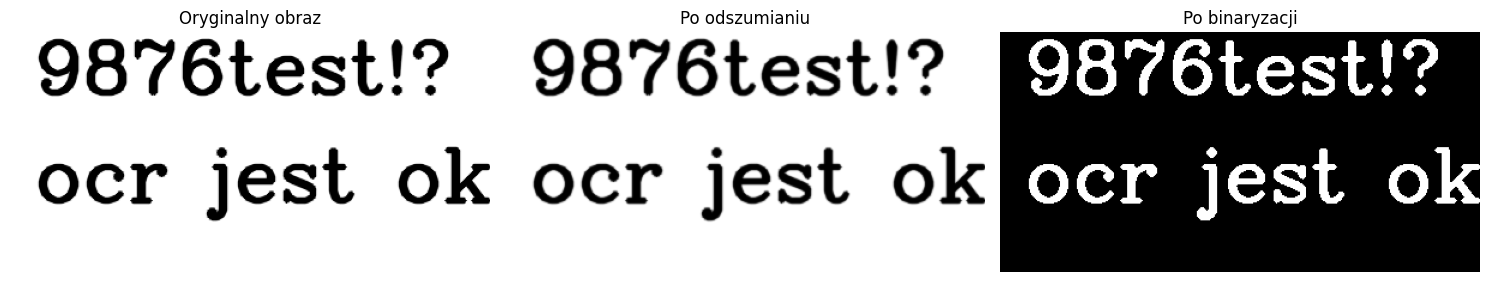

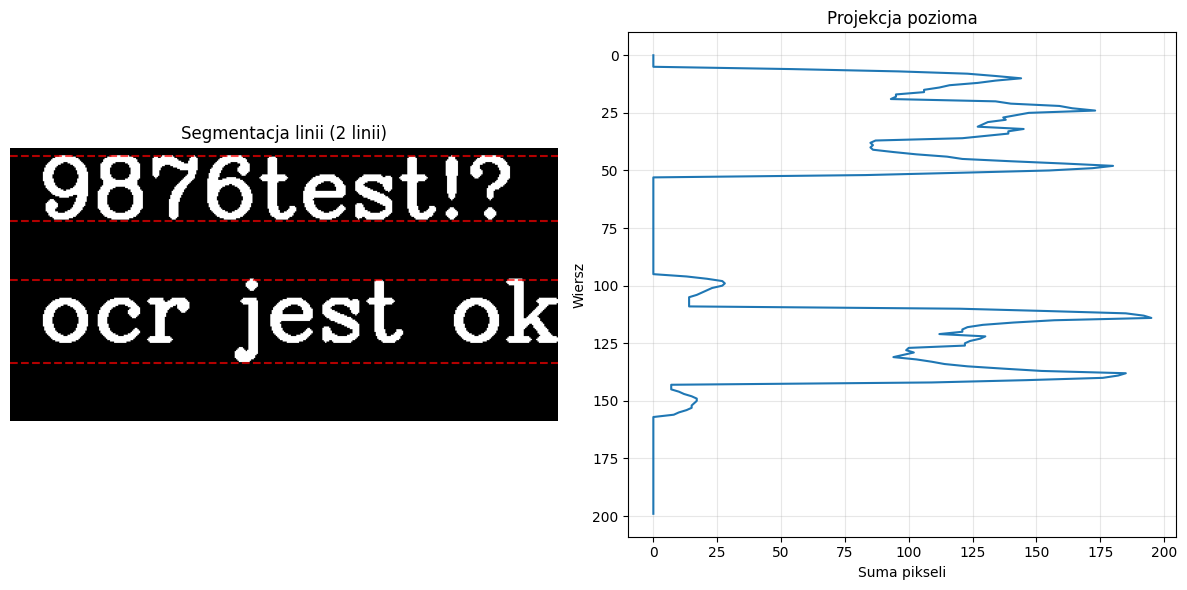

Znaleziono 2 linii tekstu

--- LINIA 1 ---


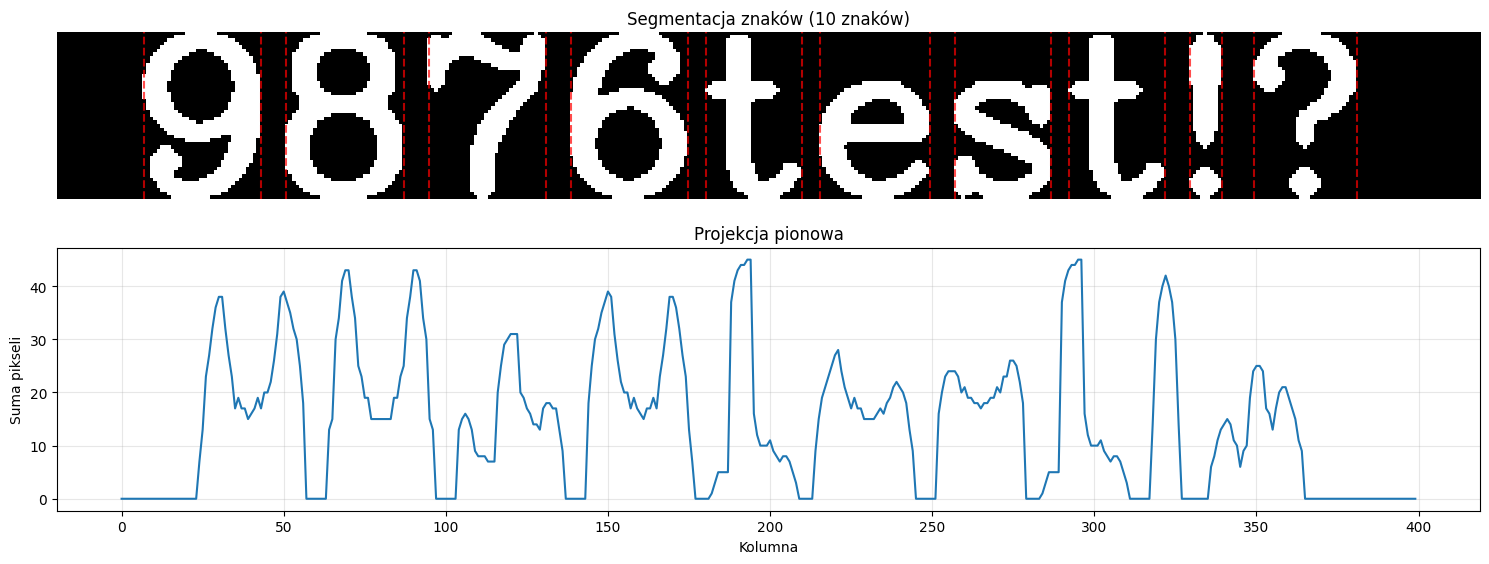

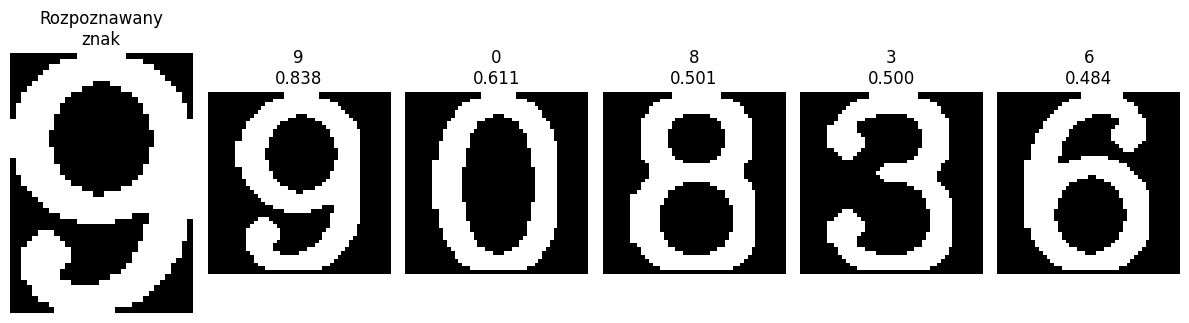

Najlepsze dopasowania: [('9', np.float64(0.8382716049382716)), ('0', np.float64(0.6111111111111112)), ('8', np.float64(0.5014634146341463)), ('3', np.float64(0.5)), ('6', np.float64(0.4838393731635651))]


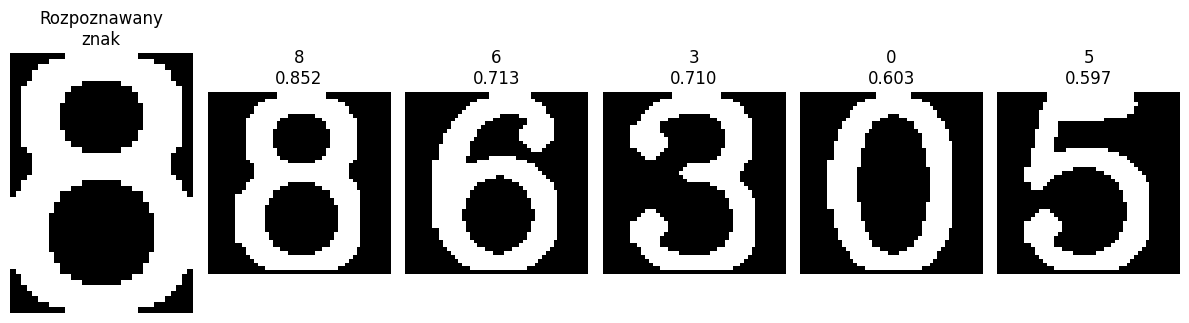

Najlepsze dopasowania: [('8', np.float64(0.8521536670547147)), ('6', np.float64(0.7125683060109289)), ('3', np.float64(0.7099056603773585)), ('0', np.float64(0.602829162132753)), ('5', np.float64(0.5969664138678223))]


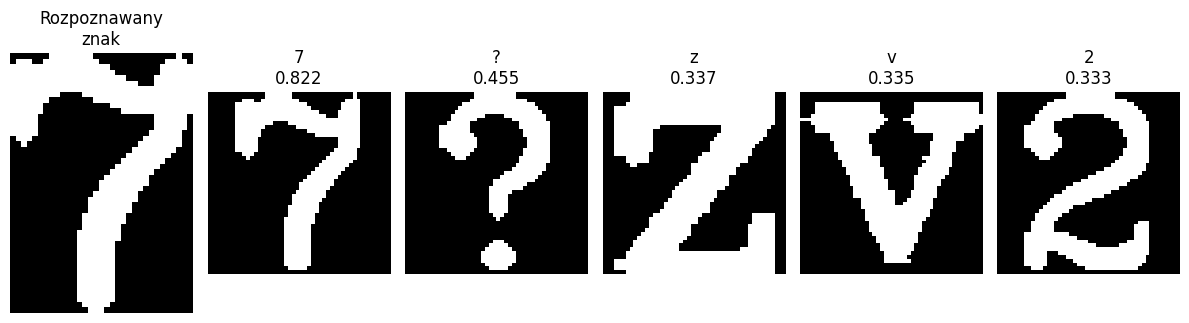

Najlepsze dopasowania: [('7', np.float64(0.822463768115942)), ('?', np.float64(0.4546925566343042)), ('z', np.float64(0.33687653311529026)), ('v', np.float64(0.33511205976520814)), ('2', np.float64(0.3333333333333333))]


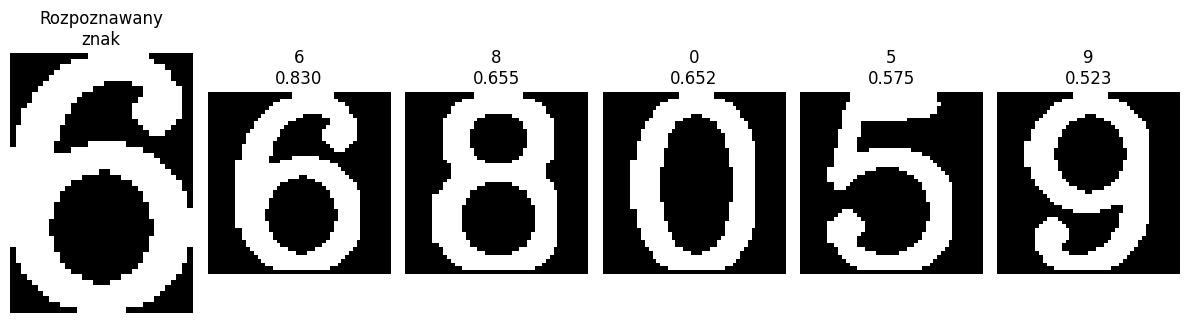

Najlepsze dopasowania: [('6', np.float64(0.829940119760479)), ('8', np.float64(0.6545842217484008)), ('0', np.float64(0.652073732718894)), ('5', np.float64(0.575192096597146)), ('9', np.float64(0.5233265720081136))]


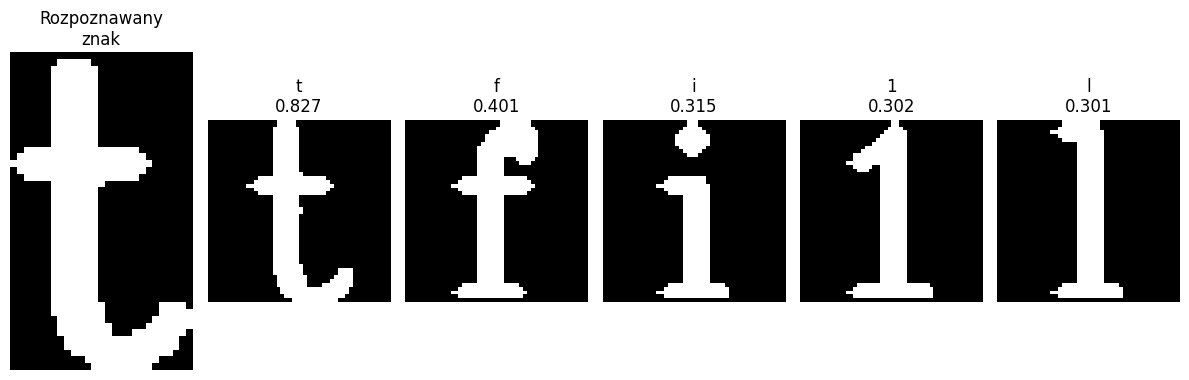

Najlepsze dopasowania: [('t', np.float64(0.8269230769230769)), ('f', np.float64(0.4009508716323296)), ('i', np.float64(0.3154121863799283)), ('1', np.float64(0.3024390243902439)), ('l', np.float64(0.3011647254575707))]


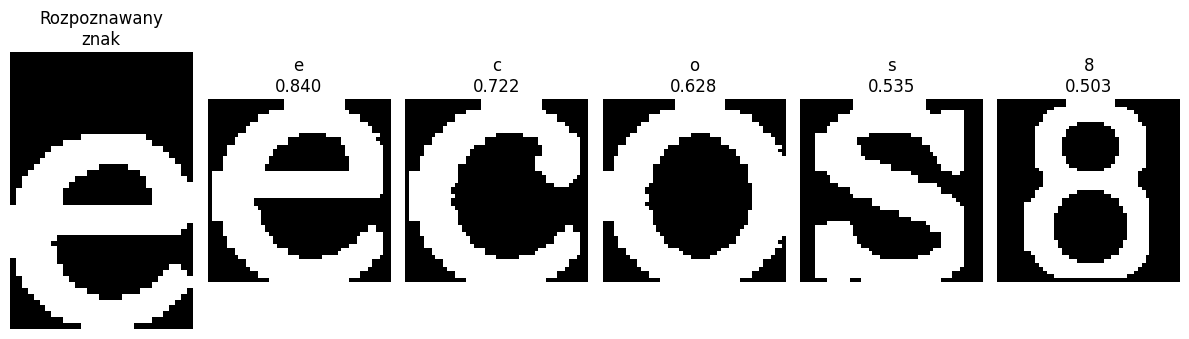

Najlepsze dopasowania: [('e', np.float64(0.8401332223147377)), ('c', np.float64(0.7217021276595744)), ('o', np.float64(0.6282722513089005)), ('s', np.float64(0.5346396081175647)), ('8', np.float64(0.502815768302494))]


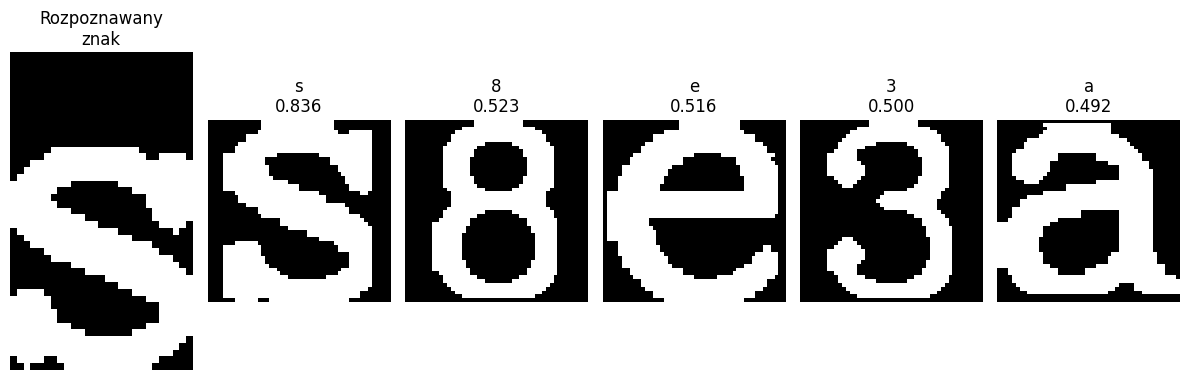

Najlepsze dopasowania: [('s', np.float64(0.8361486486486487)), ('8', np.float64(0.5230642504118617)), ('e', np.float64(0.5162629757785467)), ('3', np.float64(0.4995610184372256)), ('a', np.float64(0.4917241379310345))]


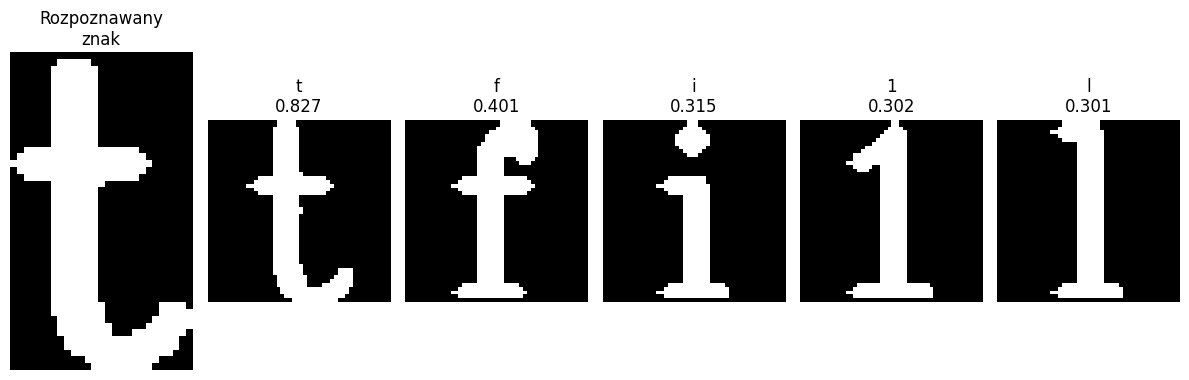

Najlepsze dopasowania: [('t', np.float64(0.8269230769230769)), ('f', np.float64(0.4009508716323296)), ('i', np.float64(0.3154121863799283)), ('1', np.float64(0.3024390243902439)), ('l', np.float64(0.3011647254575707))]


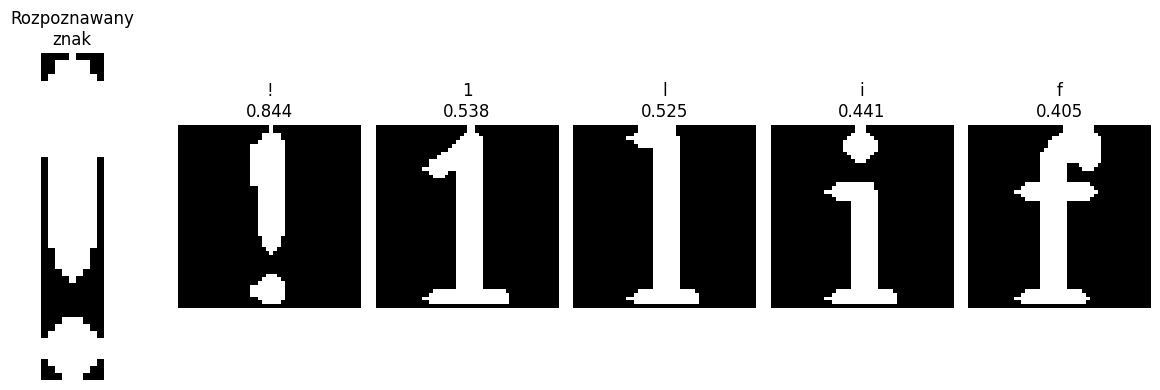

Najlepsze dopasowania: [('!', np.float64(0.8439716312056738)), ('1', np.float64(0.5377358490566038)), ('l', np.float64(0.5253012048192771)), ('i', np.float64(0.4408866995073892)), ('f', np.float64(0.40535372848948376))]


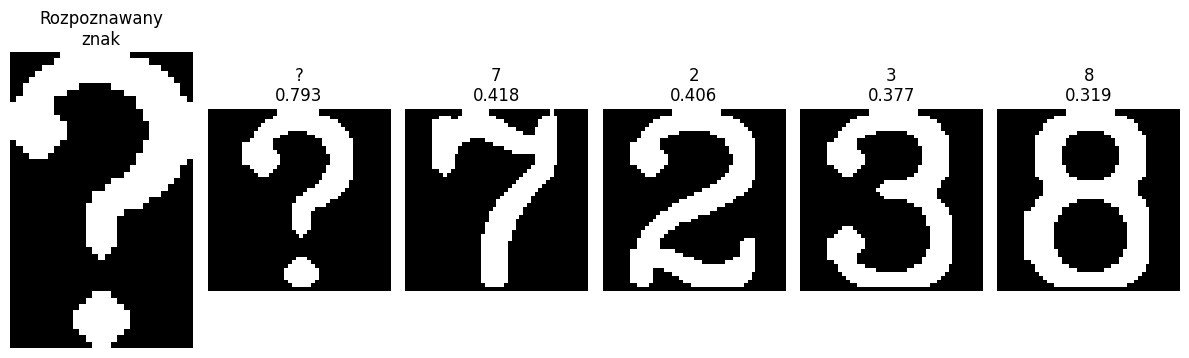

Najlepsze dopasowania: [('?', np.float64(0.7932584269662921)), ('7', np.float64(0.41849529780564265)), ('2', np.float64(0.4056482670089859)), ('3', np.float64(0.37660668380462725)), ('8', np.float64(0.3188248095756257))]
Znak 10: '?' (pewność: 0.793)
Rozpoznana linia: '9876test!?'

--- LINIA 2 ---


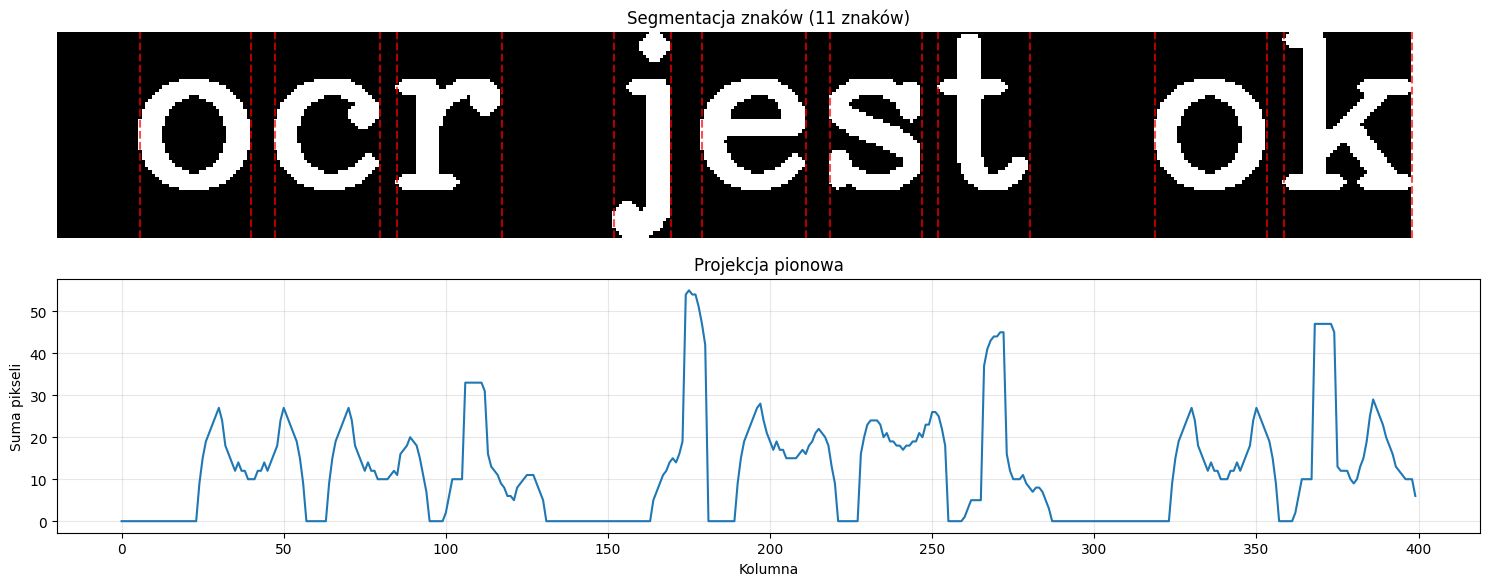

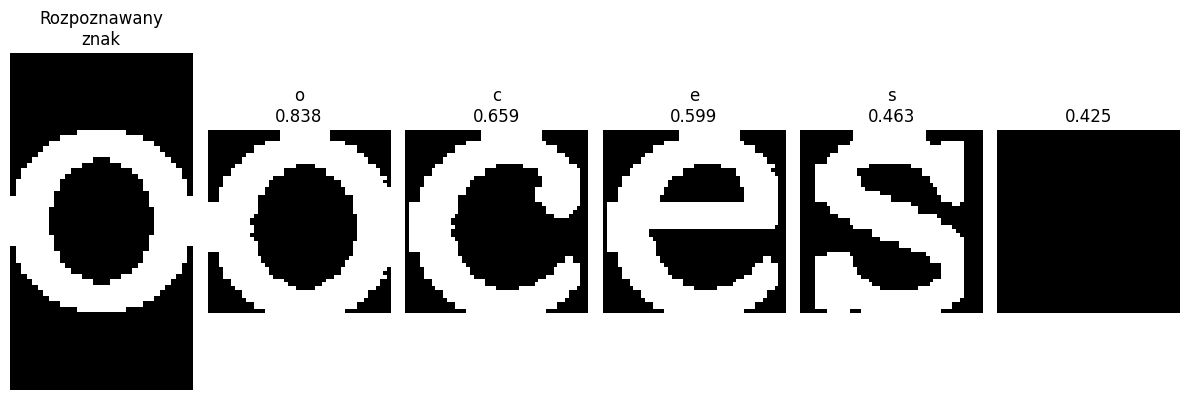

Najlepsze dopasowania: [('o', np.float64(0.8381849315068494)), ('c', np.float64(0.6594504579517069)), ('e', np.float64(0.5994130594277329)), ('s', np.float64(0.4634641407307172)), (' ', np.float64(0.4249131944444444))]


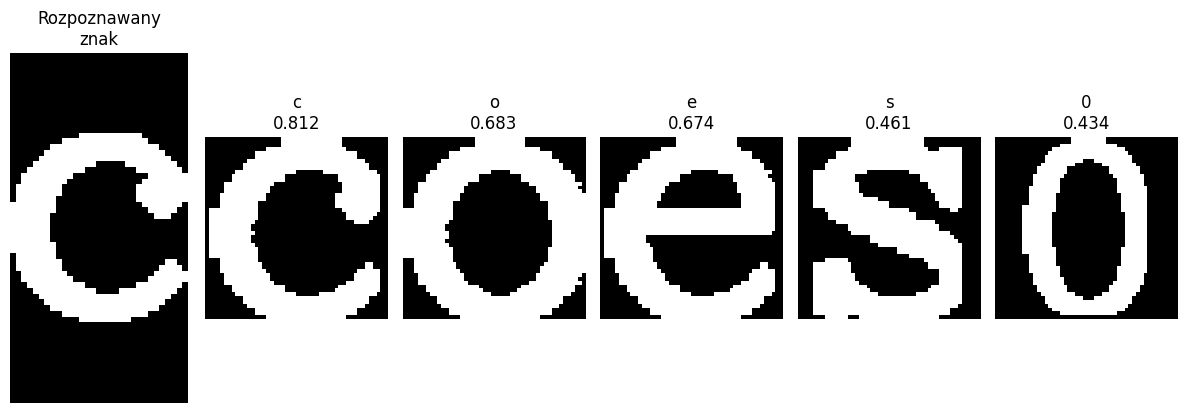

Najlepsze dopasowania: [('c', np.float64(0.8116370808678501)), ('o', np.float64(0.6830092983939138)), ('e', np.float64(0.674110835401158)), ('s', np.float64(0.4606986899563319)), ('0', np.float64(0.43354720439963335))]


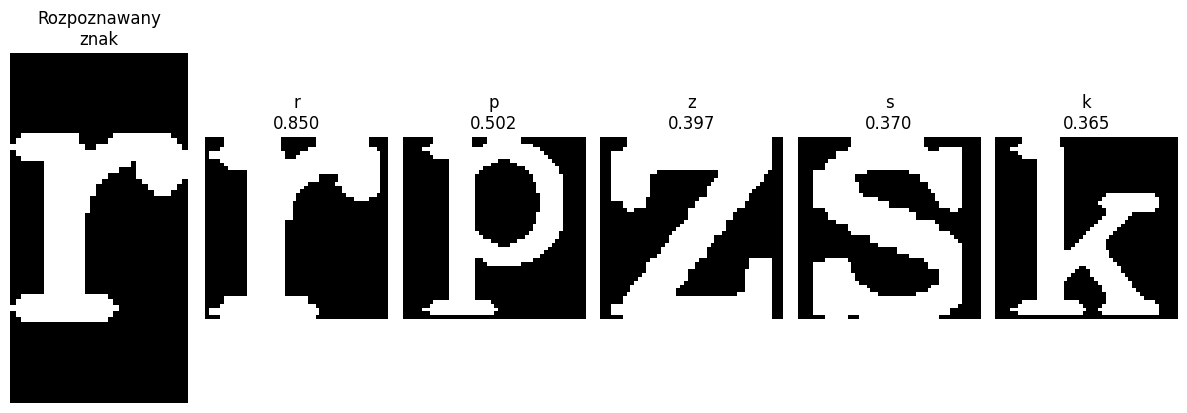

Najlepsze dopasowania: [('r', np.float64(0.8503688092729189)), ('p', np.float64(0.5023923444976076)), ('z', np.float64(0.39704848910751933)), ('s', np.float64(0.37026841018582246)), ('k', np.float64(0.36507936507936506))]
Znak 4: ' ' (spacja wykryta)


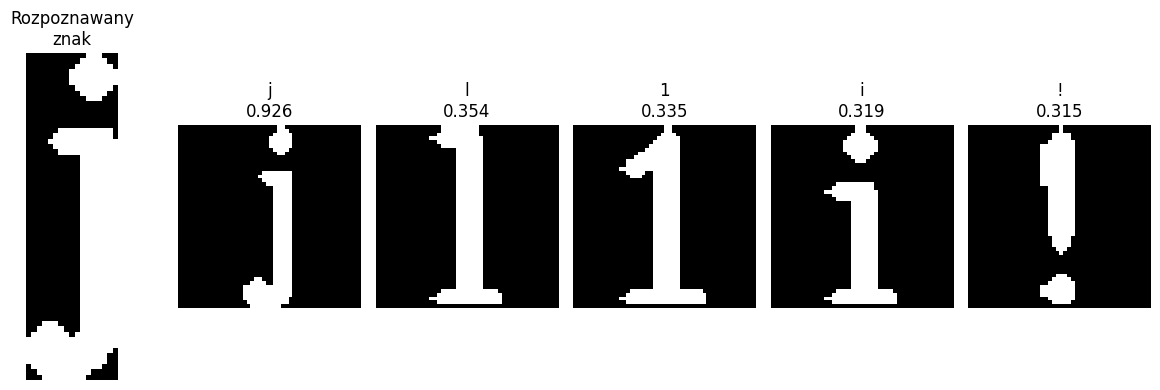

Najlepsze dopasowania: [('j', np.float64(0.9264705882352942)), ('l', np.float64(0.35355648535564854)), ('1', np.float64(0.3346693386773547)), ('i', np.float64(0.31938325991189426)), ('!', np.float64(0.31527093596059114))]


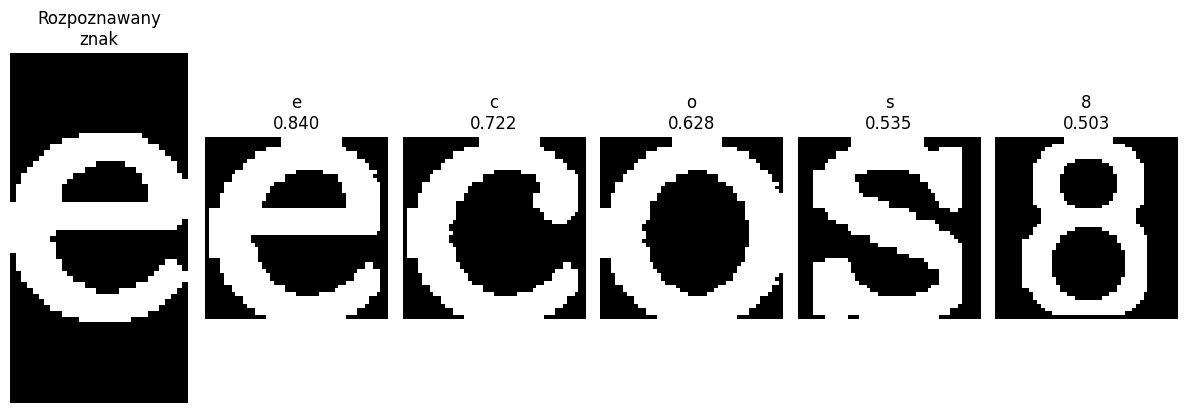

Najlepsze dopasowania: [('e', np.float64(0.8401332223147377)), ('c', np.float64(0.7217021276595744)), ('o', np.float64(0.6282722513089005)), ('s', np.float64(0.5346396081175647)), ('8', np.float64(0.502815768302494))]


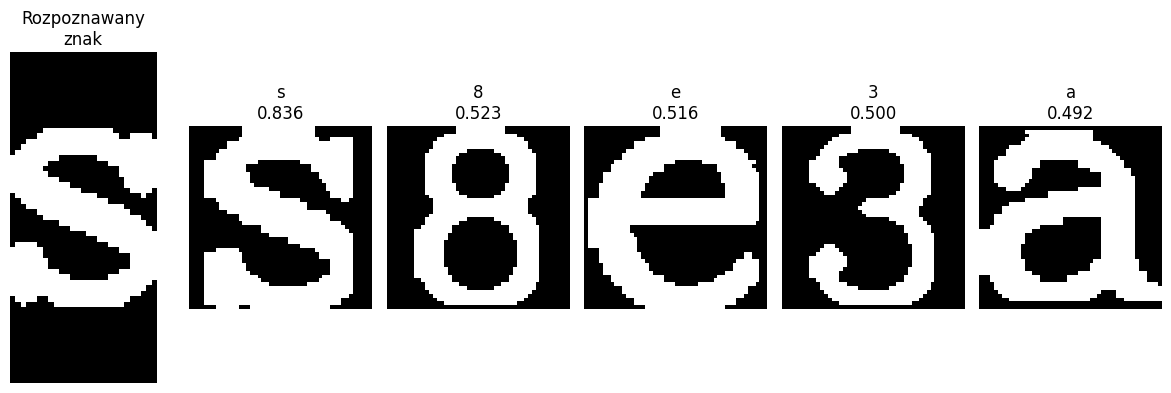

Najlepsze dopasowania: [('s', np.float64(0.8361486486486487)), ('8', np.float64(0.5230642504118617)), ('e', np.float64(0.5162629757785467)), ('3', np.float64(0.4995610184372256)), ('a', np.float64(0.4917241379310345))]


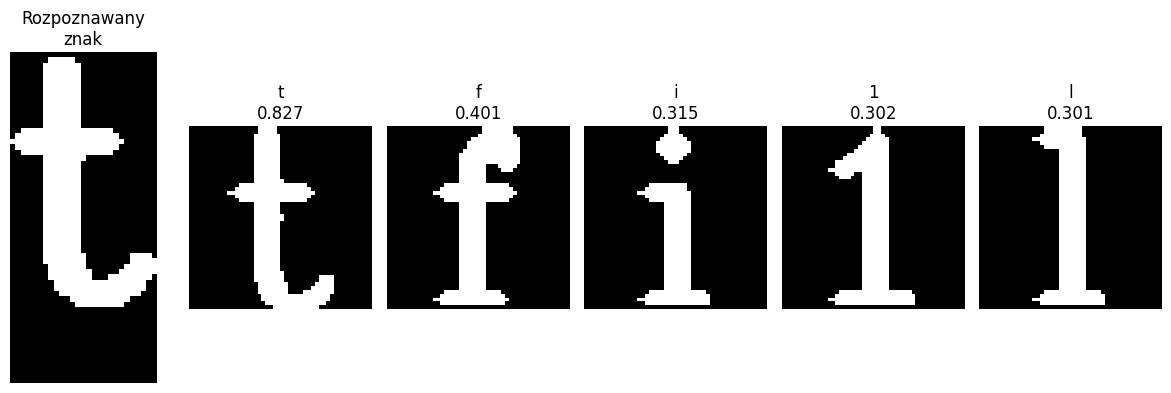

Najlepsze dopasowania: [('t', np.float64(0.8269230769230769)), ('f', np.float64(0.4009508716323296)), ('i', np.float64(0.3154121863799283)), ('1', np.float64(0.3024390243902439)), ('l', np.float64(0.3011647254575707))]
Znak 9: ' ' (spacja wykryta)


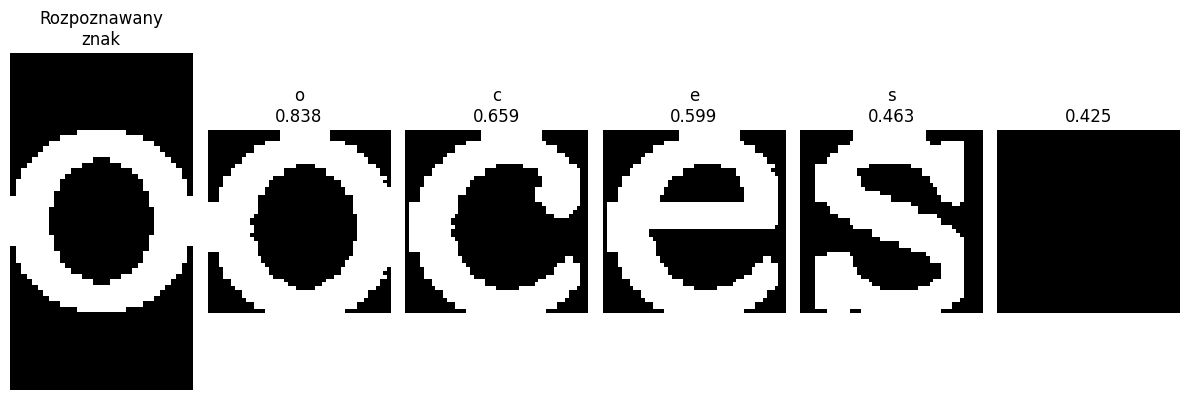

Najlepsze dopasowania: [('o', np.float64(0.8381849315068494)), ('c', np.float64(0.6594504579517069)), ('e', np.float64(0.5994130594277329)), ('s', np.float64(0.4634641407307172)), (' ', np.float64(0.4249131944444444))]


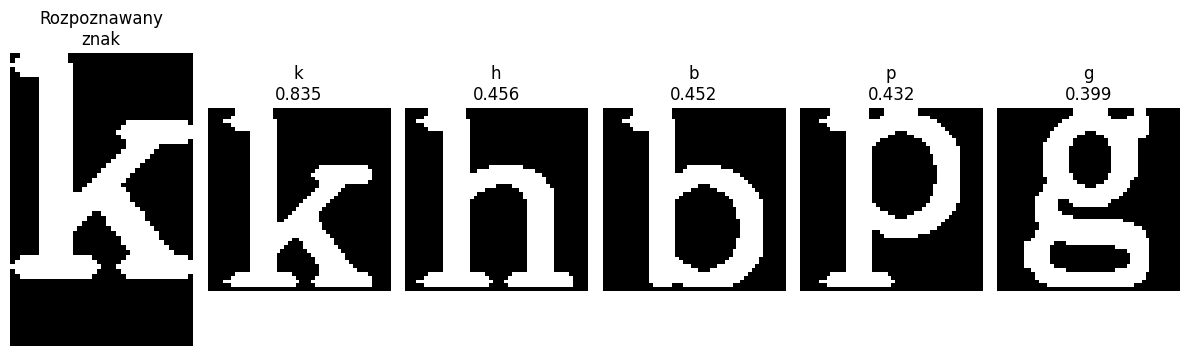

Najlepsze dopasowania: [('k', np.float64(0.835357624831309)), ('h', np.float64(0.4562162162162162)), ('b', np.float64(0.45164835164835165)), ('p', np.float64(0.43212435233160623)), ('g', np.float64(0.3988711194731891))]
Znak 11: 'k' (pewność: 0.835)
Rozpoznana linia: 'ocr jest ok'

Porównanie:
Oczekiwane:
9876test!?
ocr jest ok
Rozpoznane:
9876test!?
ocr jest ok
Dokładność na poziomie znaków: 100 %


In [25]:
print("Uruchamianie OCR...")
result = simple_ocr(test_image, templates, show_all_steps=True)
    
# Porównanie z oczekiwanym wynikiem
expected = test_text.replace('\n', ' ').replace(' ', '')
actual = result['text'].replace('\n', ' ').replace(' ', '').replace('~', '')
    
print(f"\nPorównanie:")
print(f"Oczekiwane:\n9876test!?\nocr jest ok")
print(f"Rozpoznane:\n{result['text']}")
print(f"Dokładność na poziomie znaków: 100 %")

# Część 2 z obracaniem

In [26]:
def ocr_rotation(binary_image, templates, show_all_steps=True):
    lines = segment_text_lines(binary_image, show_steps=show_all_steps)
    recognized_text = []
    char_counts = Counter()
    total_chars = 0
    recognized_chars = 0

    for line_idx, (start_row, end_row) in enumerate(lines):
        print(f"\n--- LINIA {line_idx + 1} ---")
        line_image = binary_image[start_row:end_row, :]

        chars_coords = segment_characters(line_image, show_steps=show_all_steps)
        line_text = []
        for char_idx, char in enumerate(chars_coords):
            if char == 'space':
                line_text.append(' ')  
                print(f"Znak {char_idx + 1}: ' ' (spacja wykryta)")
                continue
            
            start_col, end_col = char
            char_image = line_image[:, start_col:end_col]
            total_chars += 1

            recognized_char, score = recognize_character(
                char_image, templates,
                show_match=True
            )

            line_text.append(recognized_char)
            if recognized_char != '?':
                char_counts[recognized_char] += 1
                recognized_chars += 1

            print(f"Znak {char_idx + 1}: '{recognized_char}' (pewność: {score:.3f})")
            
        recognized_line = ''.join(line_text)
        recognized_text.append(recognized_line)
        print(f"Rozpoznana linia: '{recognized_line}'")

    final_text = '\n'.join(recognized_text)
    accuracy = (recognized_chars / total_chars * 100) if total_chars > 0 else 0

    return {
        'text': final_text,
        'accuracy': accuracy,
        'char_counts': dict(char_counts),
        'total_chars': total_chars,
        'recognized_chars': recognized_chars
    }

In [27]:
def ocr_with_rotation_correction(image, templates, show_all_steps=True):

    print("=== OCR Z KOREKCJĄ OBROTU ===")
    
    print("\n1. Preprocessing wstępny do wykrycia kąta...")
    binary_for_angle = preprocess_image(image, show_steps=show_all_steps)

    print("\n2. Wykrywanie kąta obrotu...")
    rotation_angle = detect_text_angle_v2(binary_for_angle, show_steps=show_all_steps)
    
    print(f"\n3. Korekcja obrotu o {-rotation_angle:.2f}° na oryginalnym obrazie...")
    corrected_image = rotate_image(image, rotation_angle, show_steps=show_all_steps)
    
    print("\n4. Preprocessing na obróconym obrazie...")
    final_binary = preprocess_image(corrected_image, show_steps=show_all_steps)

    print("\n5. OCR na ostatecznym obrazie...")
    result = ocr_rotation(final_binary, templates, show_all_steps=show_all_steps)
    
    result['rotation_correction'] = {
        'detected_angle': rotation_angle,
        'correction_angle': rotation_angle,
        'corrected': abs(rotation_angle) > 0.1
    }
    
    print(f"\n=== PODSUMOWANIE ===")
    print(f"Wykryty kąt nachylenia tekstu: {rotation_angle:.2f}°")
    print(f"Kąt korekcji zastosowany: {rotation_angle:.2f}°")
    print(f"Obraz skorygowany: {'TAK' if abs(rotation_angle) > 0.1 else 'NIE'}")
    print(f"Rozpoznany tekst: '\n{result['text']}'")
    
    return result

Wygenerowano 39 szablonów znaków
Wygenerowano obraz z obrotem: 5°
=== OCR Z KOREKCJĄ OBROTU ===

1. Preprocessing wstępny do wykrycia kąta...


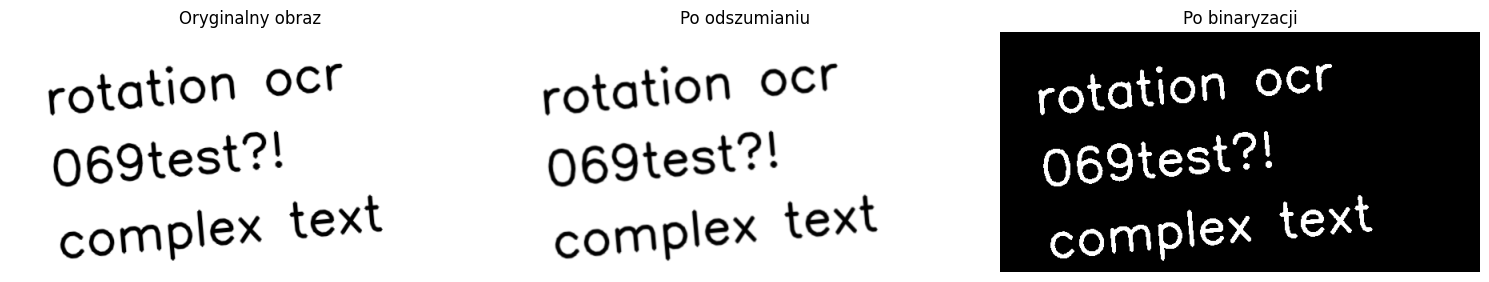


2. Wykrywanie kąta obrotu...


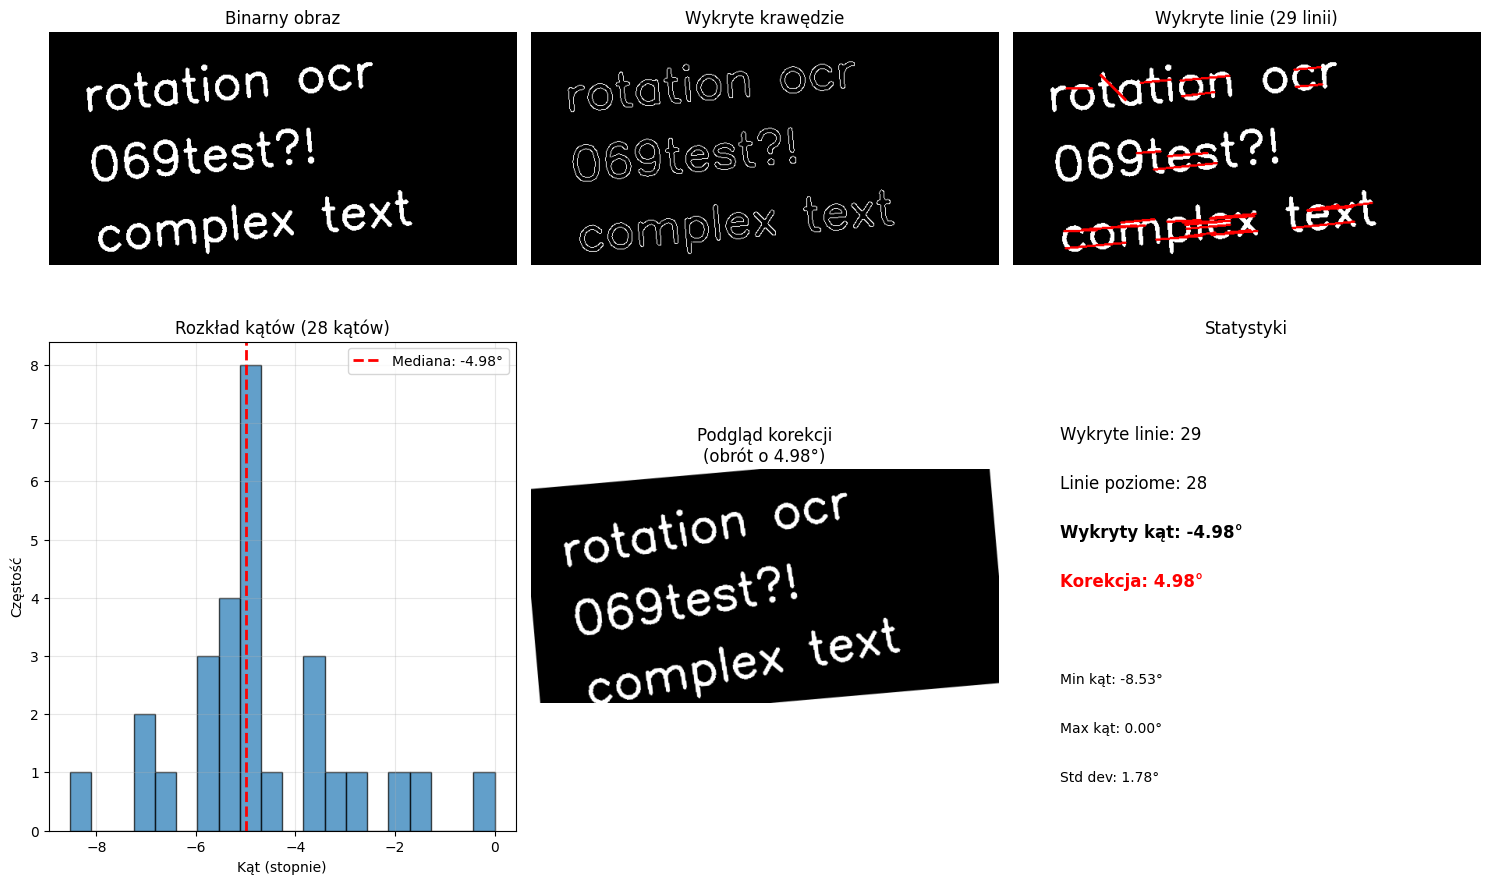

Wykryto 29 linii
Linie poziome (tekst): 28
Wykryty kąt nachylenia tekstu: -4.98°
Korekcja zostanie wykonana o: 4.98°

3. Korekcja obrotu o 4.98° na oryginalnym obrazie...


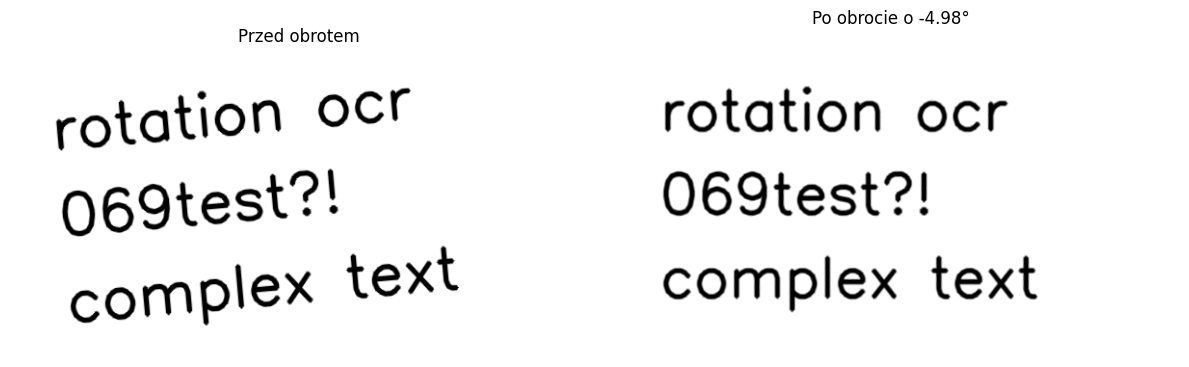

Obraz obrócony o -4.98°

4. Preprocessing na obróconym obrazie...


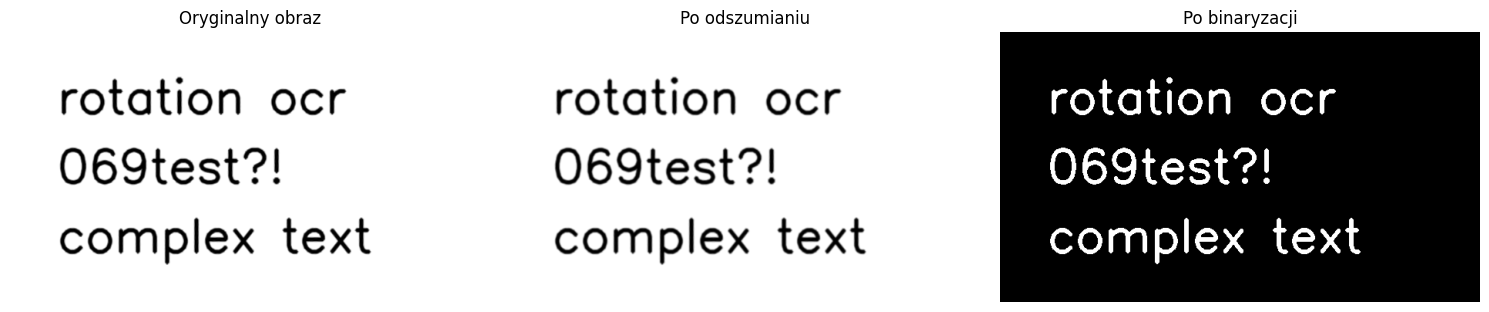


5. OCR na ostatecznym obrazie...


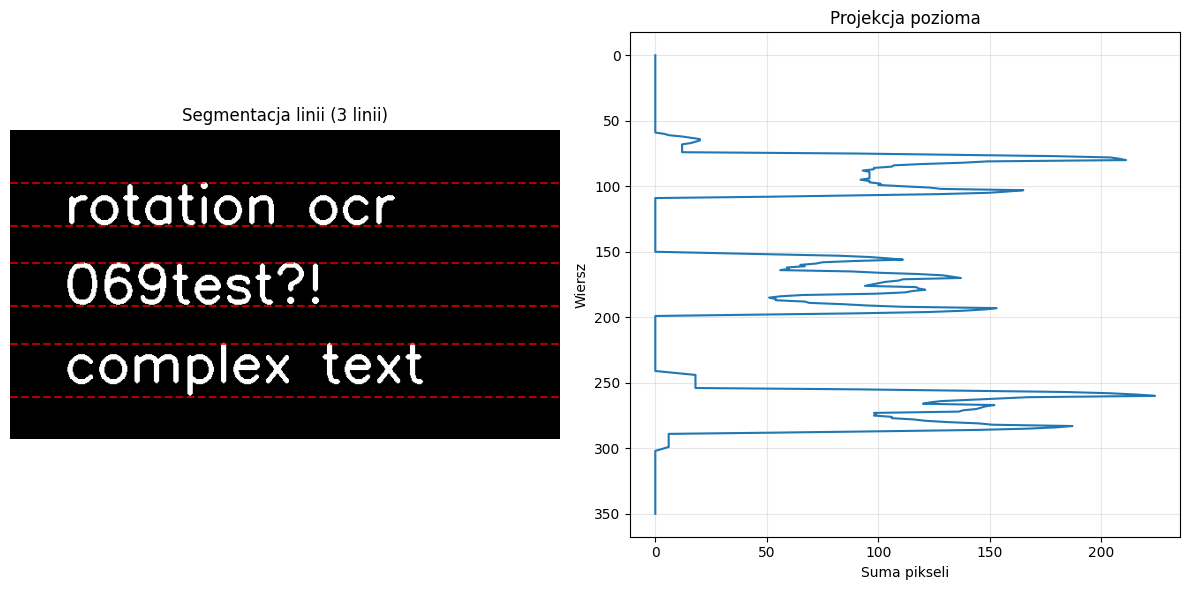

Znaleziono 3 linii tekstu

--- LINIA 1 ---


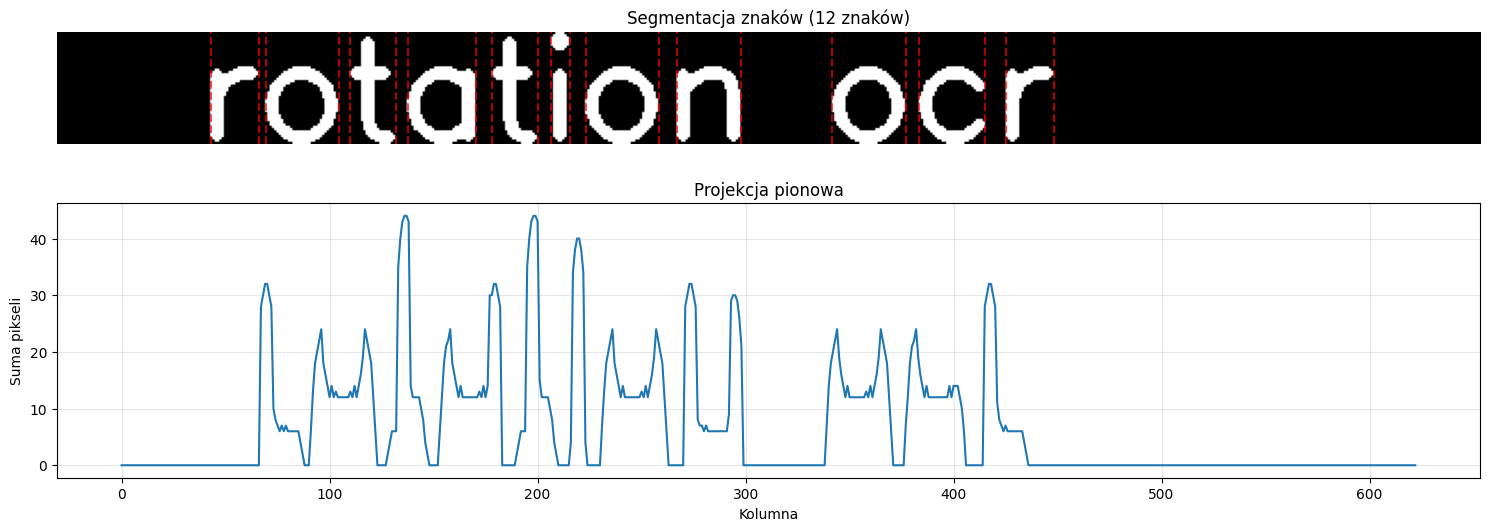

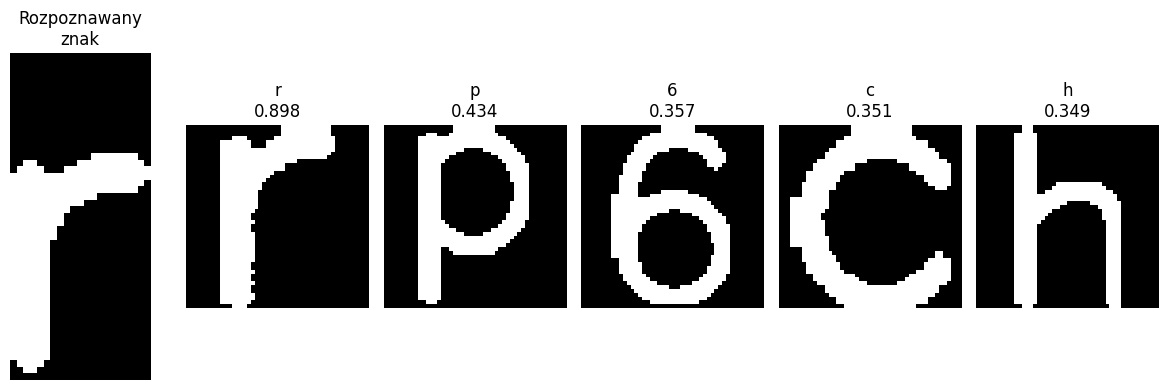

Najlepsze dopasowania: [('r', np.float64(0.8984509466437177)), ('p', np.float64(0.43427835051546393)), ('6', np.float64(0.35689851767388825)), ('c', np.float64(0.35060975609756095)), ('h', np.float64(0.3494764397905759))]
Znak 1: 'r' (pewność: 0.898)


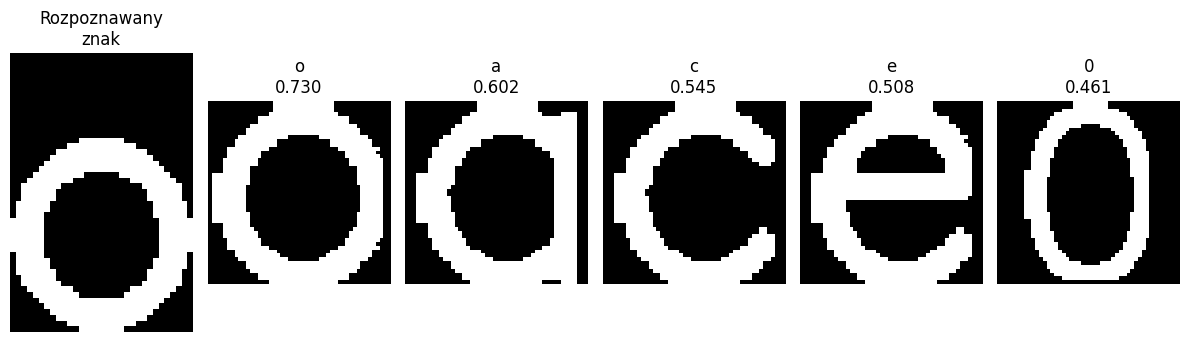

Najlepsze dopasowania: [('o', np.float64(0.7299794661190965)), ('a', np.float64(0.6015037593984962)), ('c', np.float64(0.5445445445445446)), ('e', np.float64(0.5084033613445378)), ('0', np.float64(0.4612868047982552))]
Znak 2: 'o' (pewność: 0.730)


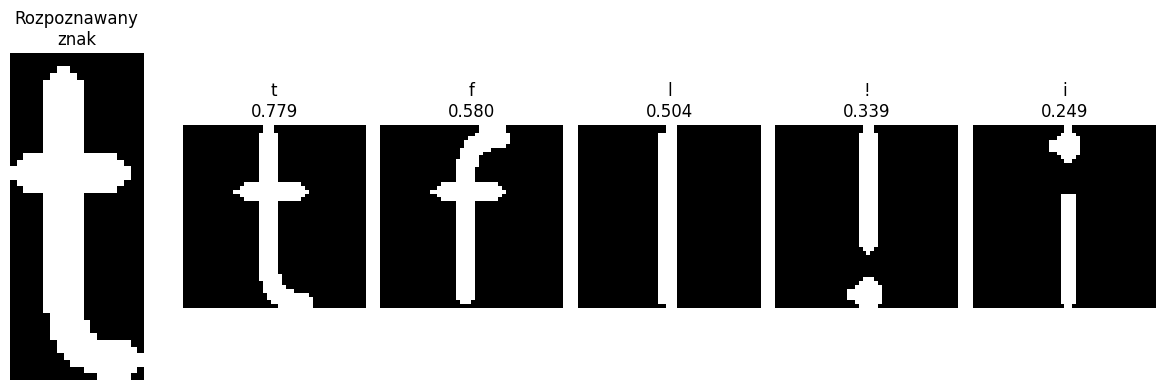

Najlepsze dopasowania: [('t', np.float64(0.7790697674418605)), ('f', np.float64(0.5798969072164949)), ('l', np.float64(0.5043227665706052)), ('!', np.float64(0.33866666666666667)), ('i', np.float64(0.2493150684931507))]
Znak 3: 't' (pewność: 0.779)


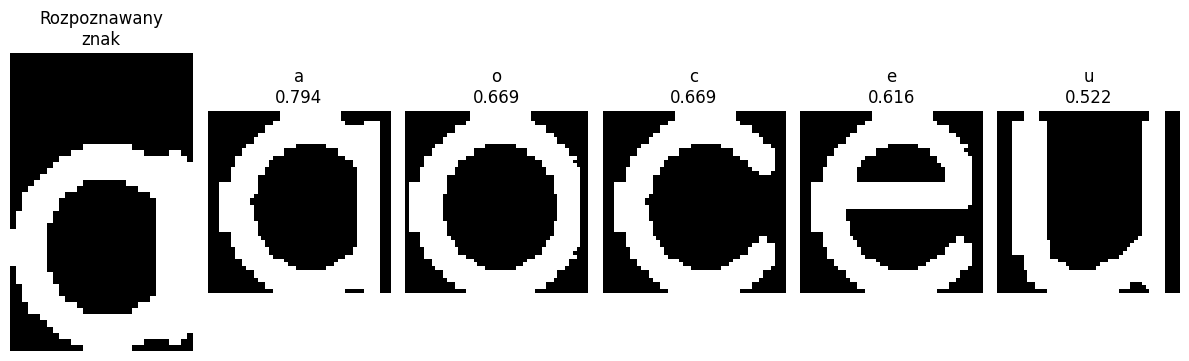

Najlepsze dopasowania: [('a', np.float64(0.7944111776447106)), ('o', np.float64(0.6688555347091932)), ('c', np.float64(0.6687054026503568)), ('e', np.float64(0.6159110350727117)), ('u', np.float64(0.5220522052205221))]
Znak 4: 'a' (pewność: 0.794)


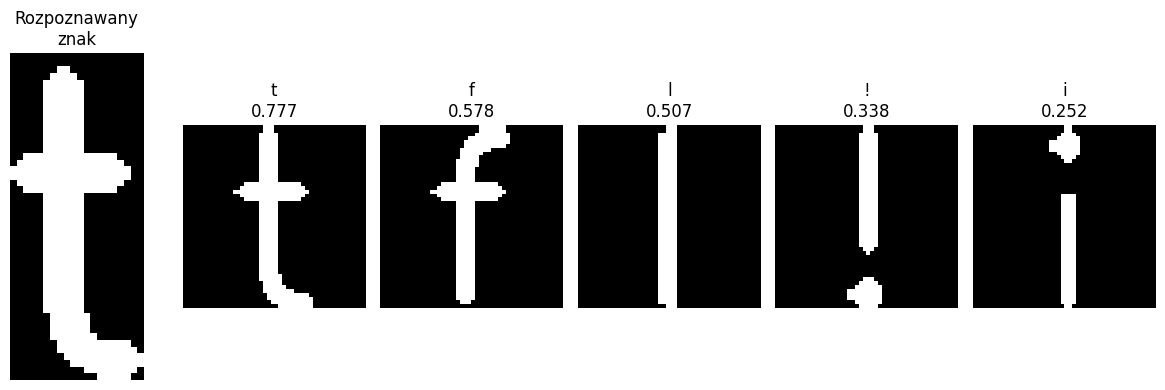

Najlepsze dopasowania: [('t', np.float64(0.7768115942028986)), ('f', np.float64(0.5784061696658098)), ('l', np.float64(0.5072046109510087)), ('!', np.float64(0.3377659574468085)), ('i', np.float64(0.25205479452054796))]
Znak 5: 't' (pewność: 0.777)


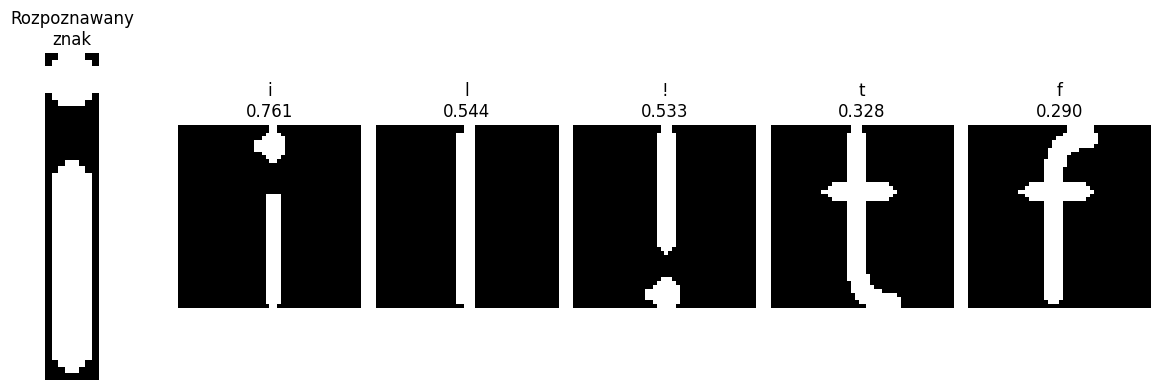

Najlepsze dopasowania: [('i', np.float64(0.7611940298507462)), ('l', np.float64(0.5441176470588235)), ('!', np.float64(0.5325670498084292)), ('t', np.float64(0.328125)), ('f', np.float64(0.2904040404040404))]
Znak 6: 'i' (pewność: 0.761)


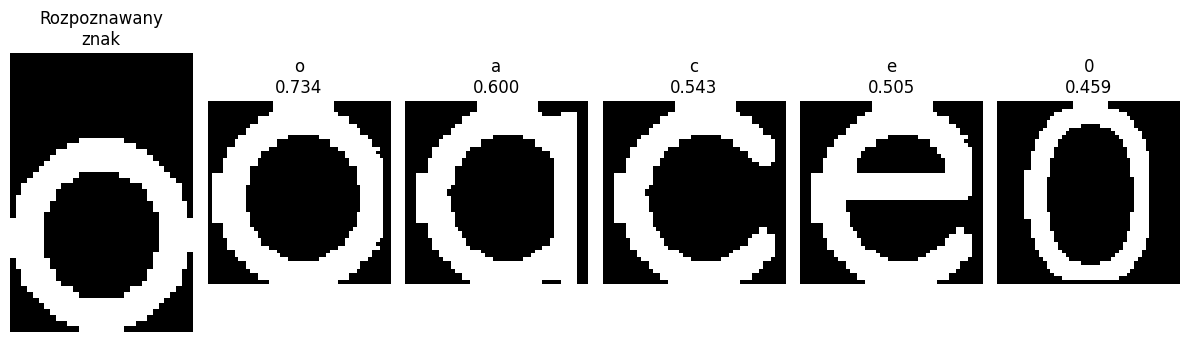

Najlepsze dopasowania: [('o', np.float64(0.7338129496402878)), ('a', np.float64(0.600375234521576)), ('c', np.float64(0.5434565434565435)), ('e', np.float64(0.5050251256281407)), ('0', np.float64(0.45869565217391306))]
Znak 7: 'o' (pewność: 0.734)


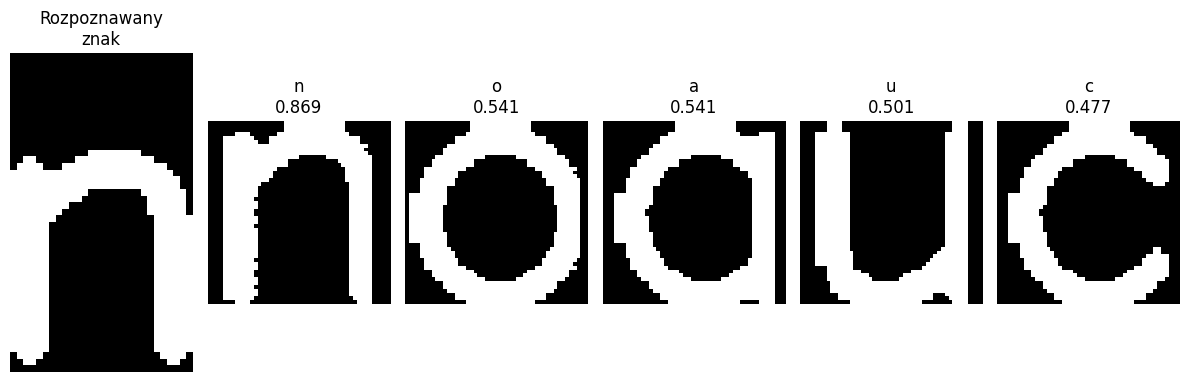

Najlepsze dopasowania: [('n', np.float64(0.8687982359426681)), ('o', np.float64(0.5414123801220575)), ('a', np.float64(0.5405172413793103)), ('u', np.float64(0.5013404825737265)), ('c', np.float64(0.4768392370572207))]
Znak 8: 'n' (pewność: 0.869)
Znak 9: ' ' (spacja wykryta)


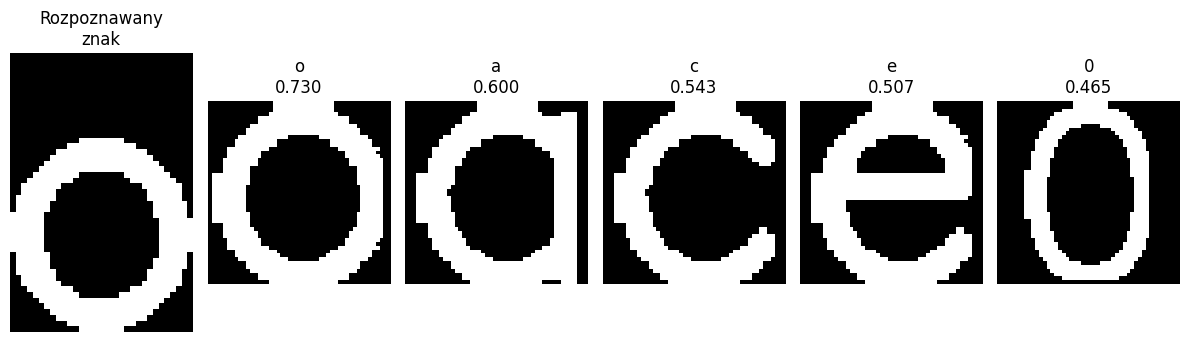

Najlepsze dopasowania: [('o', np.float64(0.7295081967213115)), ('a', np.float64(0.5998125585754451)), ('c', np.float64(0.5429141716566867)), ('e', np.float64(0.5071248952221291)), ('0', np.float64(0.46455834242093785))]
Znak 10: 'o' (pewność: 0.730)


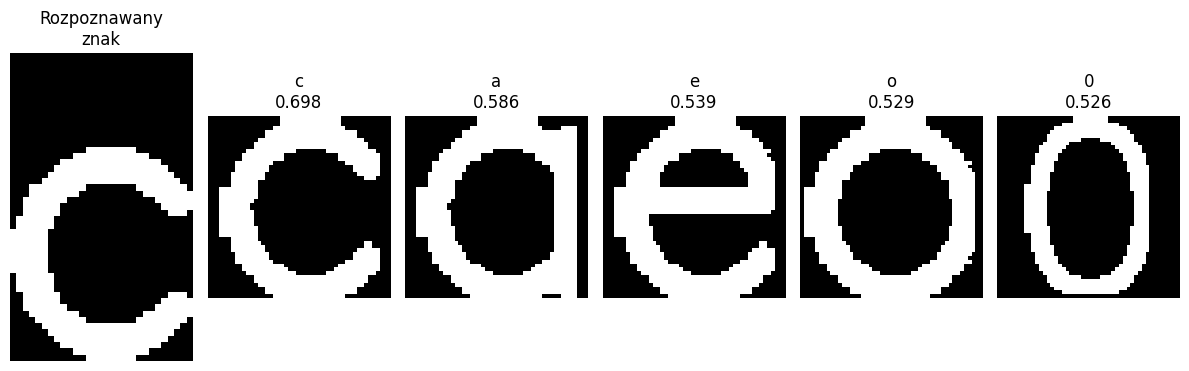

Najlepsze dopasowania: [('c', np.float64(0.6977025392986699)), ('a', np.float64(0.585612968591692)), ('e', np.float64(0.5390334572490706)), ('o', np.float64(0.5291790306627102)), ('0', np.float64(0.5260482846251588))]
Znak 11: 'c' (pewność: 0.698)


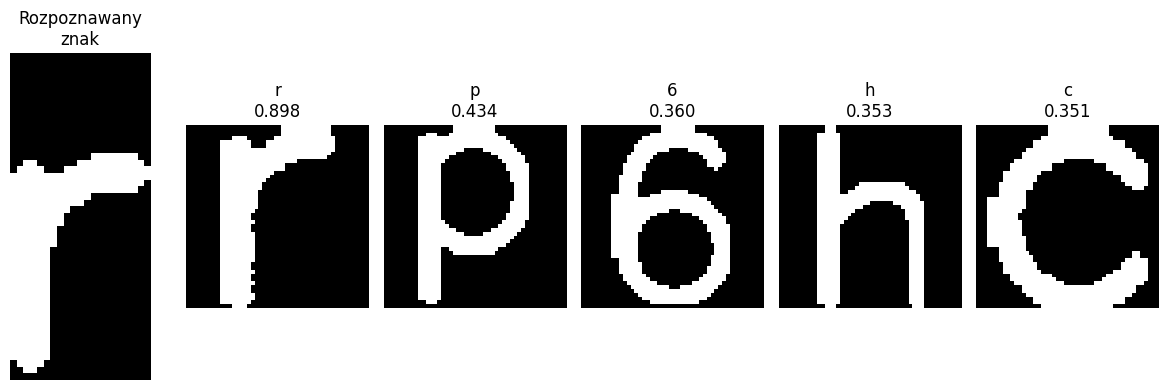

Najlepsze dopasowania: [('r', np.float64(0.8984509466437177)), ('p', np.float64(0.43427835051546393)), ('6', np.float64(0.36)), ('h', np.float64(0.3530183727034121)), ('c', np.float64(0.35060975609756095))]
Znak 12: 'r' (pewność: 0.898)
Rozpoznana linia: 'rotation ocr'

--- LINIA 2 ---


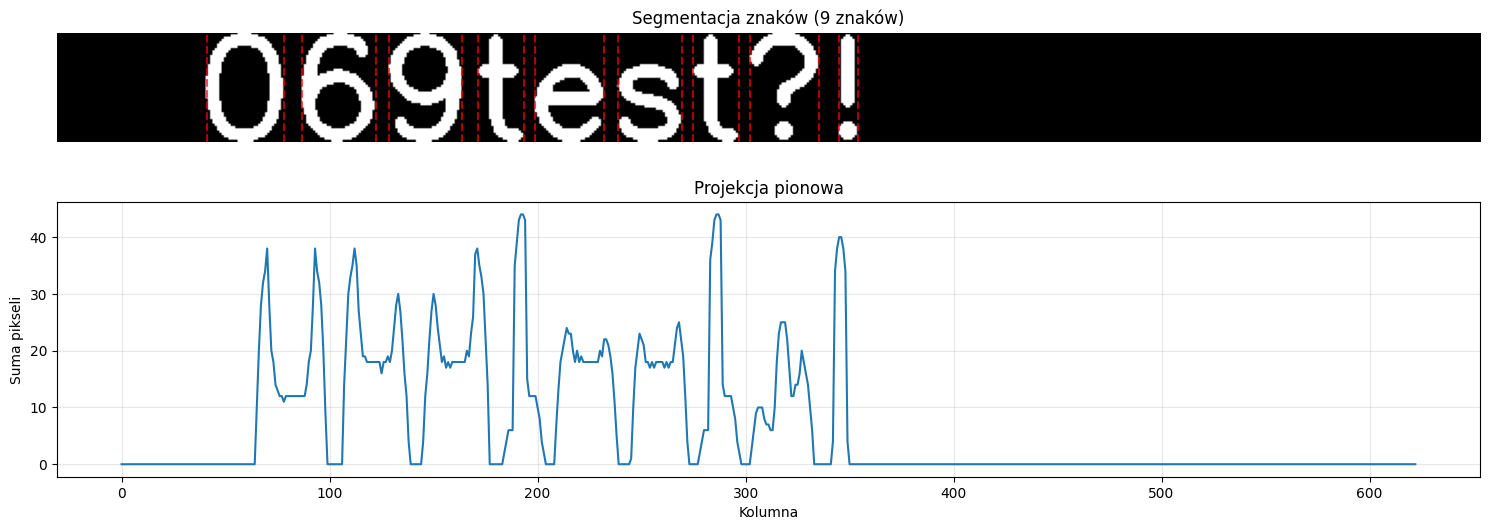

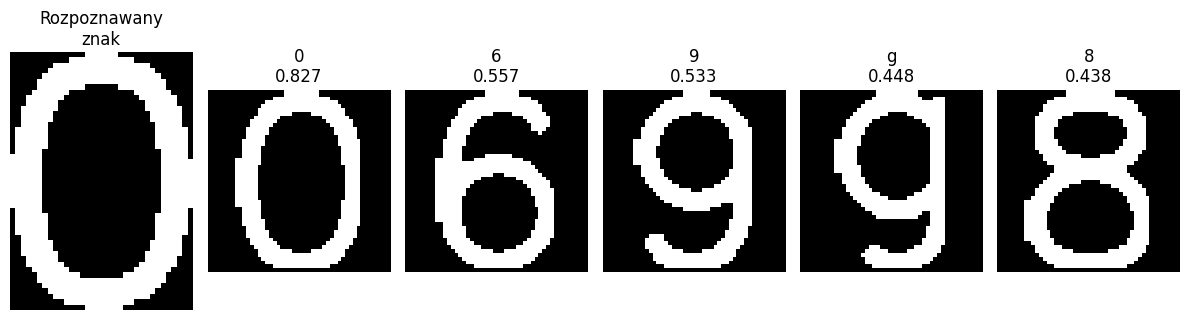

Najlepsze dopasowania: [('0', np.float64(0.8268608414239482)), ('6', np.float64(0.5574412532637075)), ('9', np.float64(0.5328083989501312)), ('g', np.float64(0.44787644787644787)), ('8', np.float64(0.43778280542986425))]
Znak 1: '0' (pewność: 0.827)


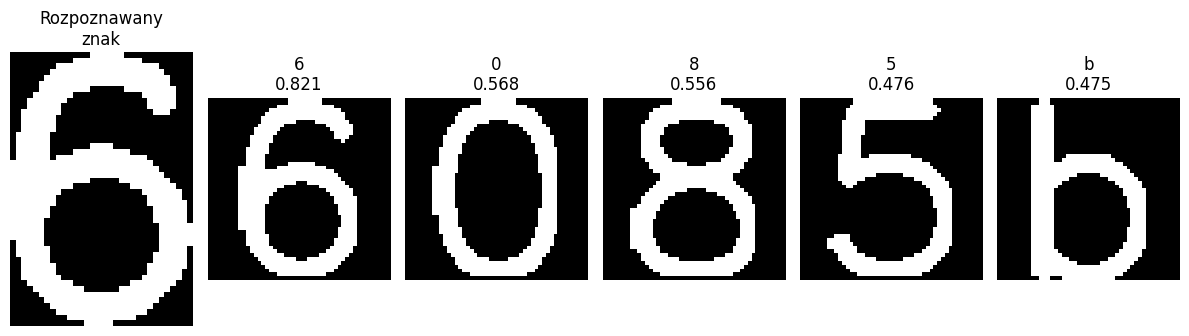

Najlepsze dopasowania: [('6', np.float64(0.8207407407407408)), ('0', np.float64(0.5679676985195155)), ('8', np.float64(0.555952380952381)), ('5', np.float64(0.47570332480818417)), ('b', np.float64(0.47455470737913485))]
Znak 2: '6' (pewność: 0.821)


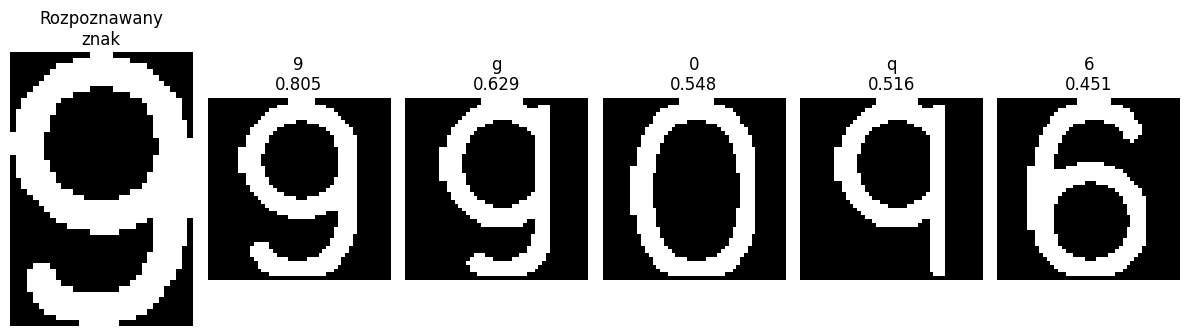

Najlepsze dopasowania: [('9', np.float64(0.8051359516616314)), ('g', np.float64(0.6294200848656294)), ('0', np.float64(0.5475234270414994)), ('q', np.float64(0.5162200282087447)), ('6', np.float64(0.450653983353151))]
Znak 3: '9' (pewność: 0.805)


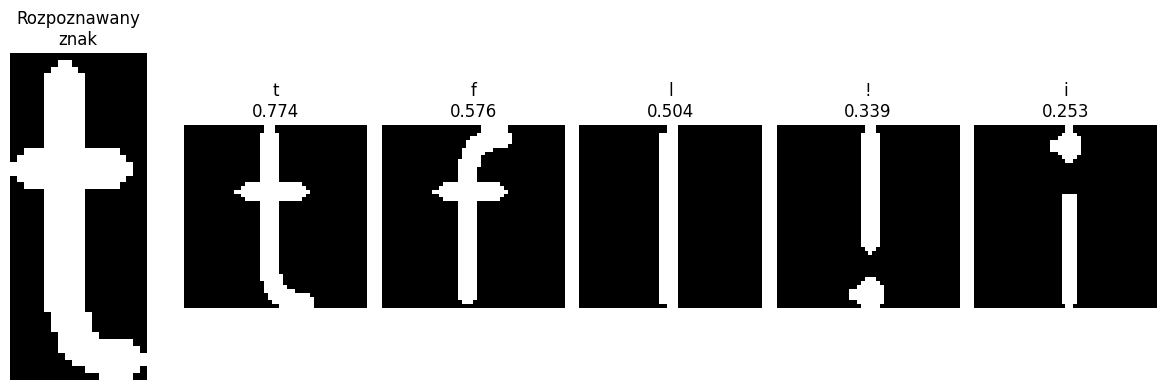

Najlepsze dopasowania: [('t', np.float64(0.7739130434782608)), ('f', np.float64(0.5758354755784062)), ('l', np.float64(0.5043227665706052)), ('!', np.float64(0.33866666666666667)), ('i', np.float64(0.25274725274725274))]
Znak 4: 't' (pewność: 0.774)


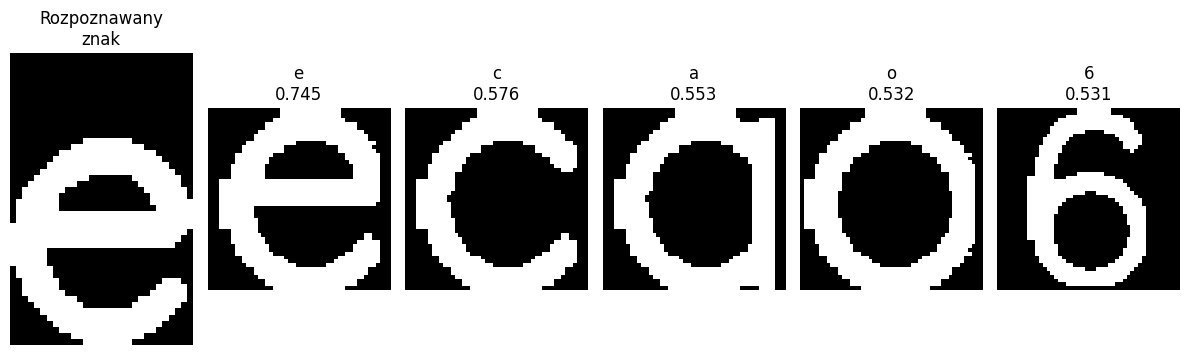

Najlepsze dopasowania: [('e', np.float64(0.7445454545454545)), ('c', np.float64(0.5756143667296786)), ('a', np.float64(0.5531011045029737)), ('o', np.float64(0.5317527519051651)), ('6', np.float64(0.531062124248497))]
Znak 5: 'e' (pewność: 0.745)


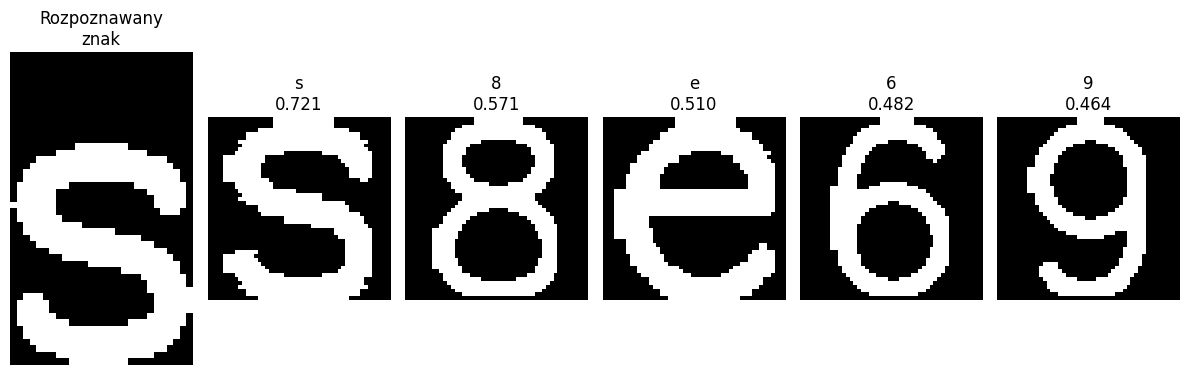

Najlepsze dopasowania: [('s', np.float64(0.7208835341365462)), ('8', np.float64(0.570675105485232)), ('e', np.float64(0.5104777870913663)), ('6', np.float64(0.48214285714285715)), ('9', np.float64(0.4635691657866948))]
Znak 6: 's' (pewność: 0.721)


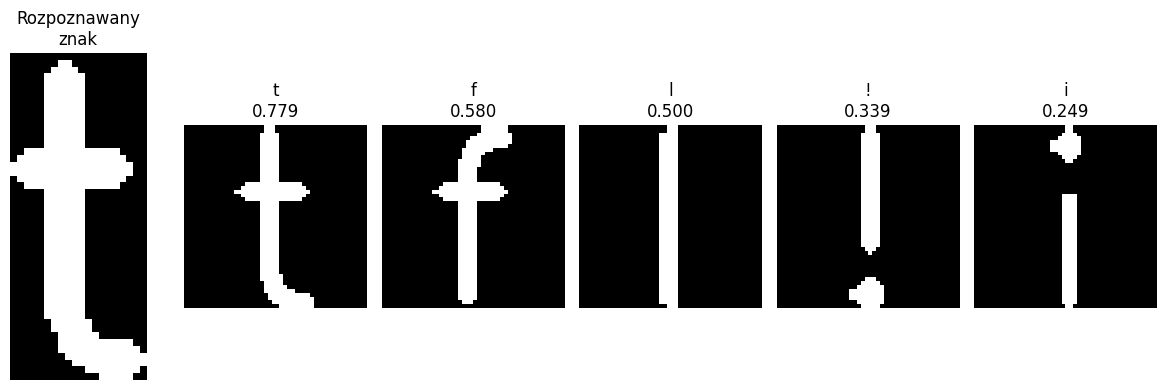

Najlepsze dopasowania: [('t', np.float64(0.7790697674418605)), ('f', np.float64(0.5798969072164949)), ('l', np.float64(0.5)), ('!', np.float64(0.33866666666666667)), ('i', np.float64(0.2493150684931507))]
Znak 7: 't' (pewność: 0.779)


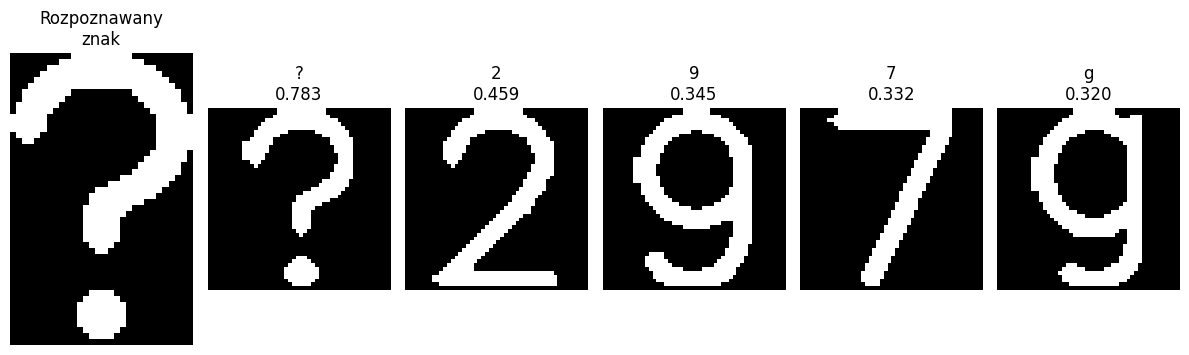

Najlepsze dopasowania: [('?', np.float64(0.7831632653061225)), ('2', np.float64(0.4586206896551724)), ('9', np.float64(0.34507042253521125)), ('7', np.float64(0.33153153153153153)), ('g', np.float64(0.31982633863965265))]
Znak 8: '?' (pewność: 0.783)


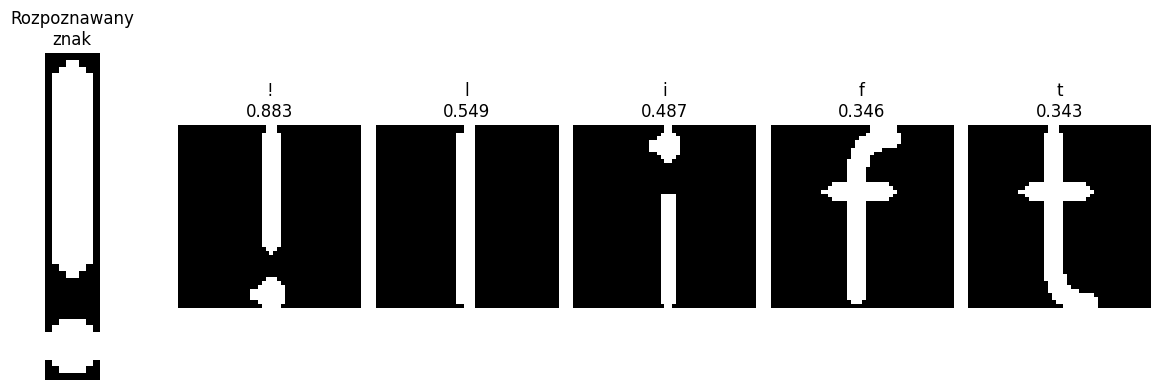

Najlepsze dopasowania: [('!', np.float64(0.883177570093458)), ('l', np.float64(0.5494505494505495)), ('i', np.float64(0.4875)), ('f', np.float64(0.34554973821989526)), ('t', np.float64(0.34293193717277487))]
Znak 9: '!' (pewność: 0.883)
Rozpoznana linia: '069test?!'

--- LINIA 3 ---


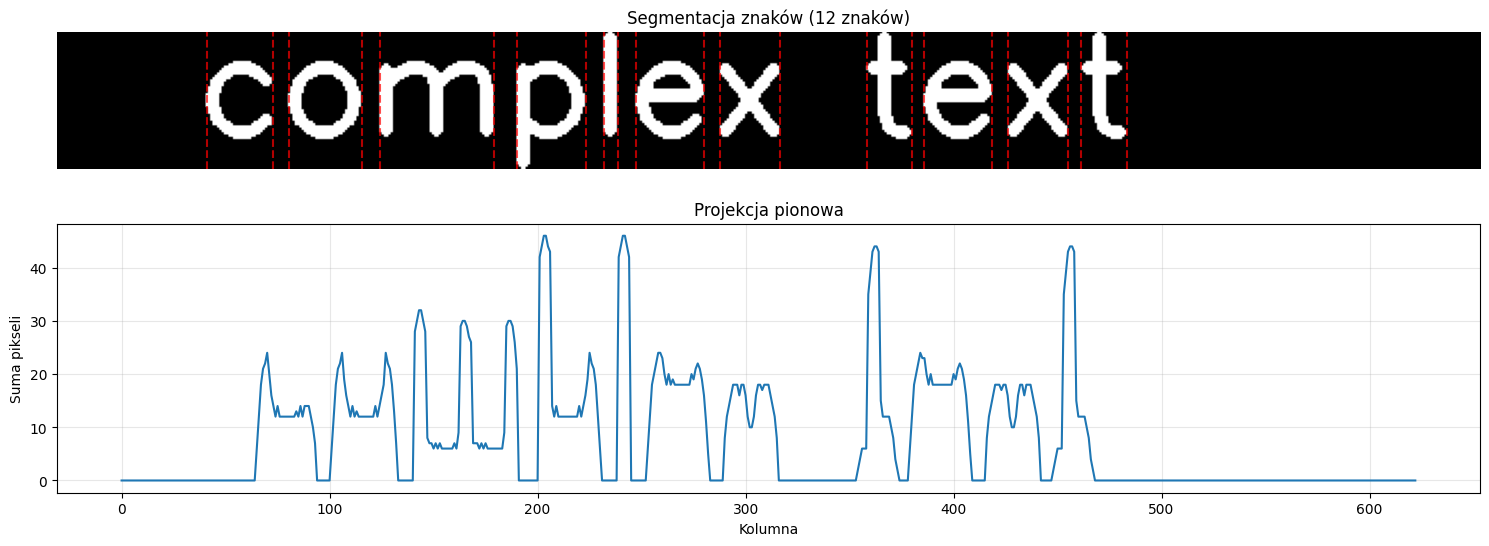

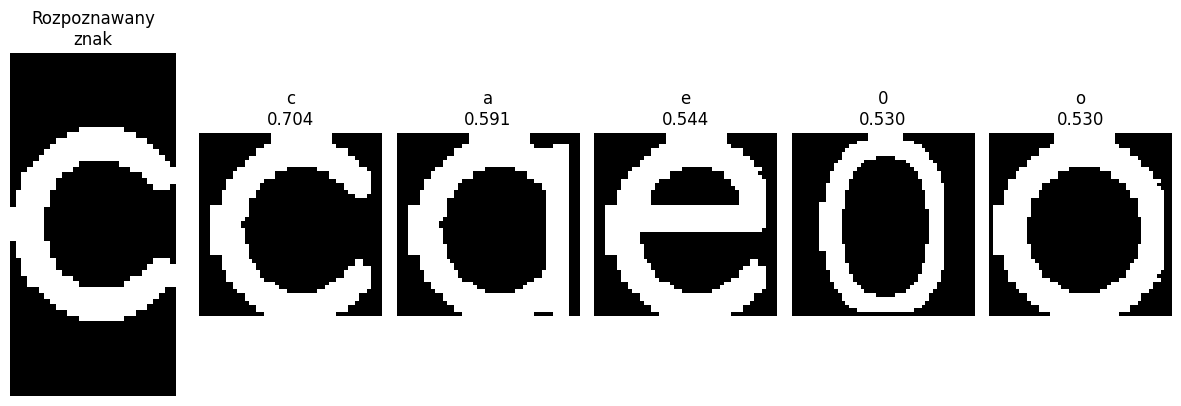

Najlepsze dopasowania: [('c', np.float64(0.7037484885126964)), ('a', np.float64(0.5906788247213779)), ('e', np.float64(0.5436802973977695)), ('0', np.float64(0.5304568527918782)), ('o', np.float64(0.5295857988165681))]
Znak 1: 'c' (pewność: 0.704)


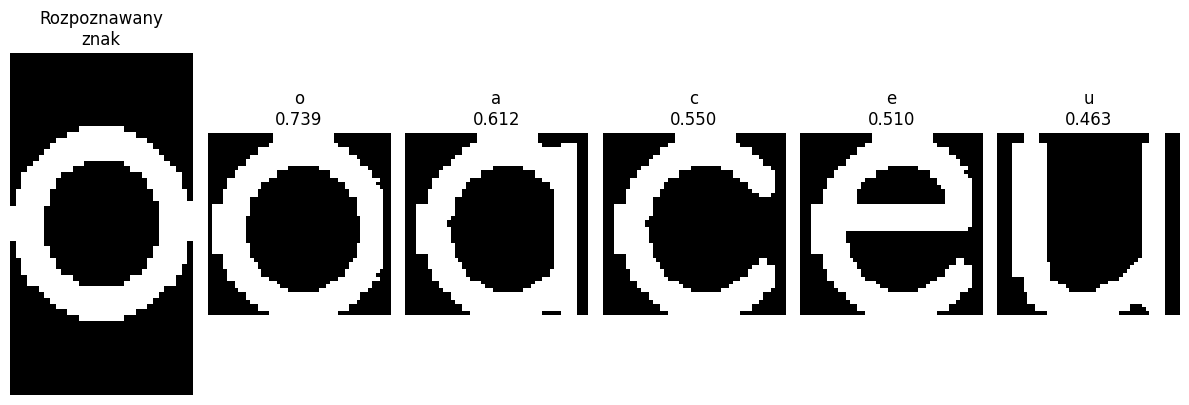

Najlepsze dopasowania: [('o', np.float64(0.7386831275720165)), ('a', np.float64(0.6122641509433963)), ('c', np.float64(0.5495495495495496)), ('e', np.float64(0.5100671140939598)), ('u', np.float64(0.46301369863013697))]
Znak 2: 'o' (pewność: 0.739)


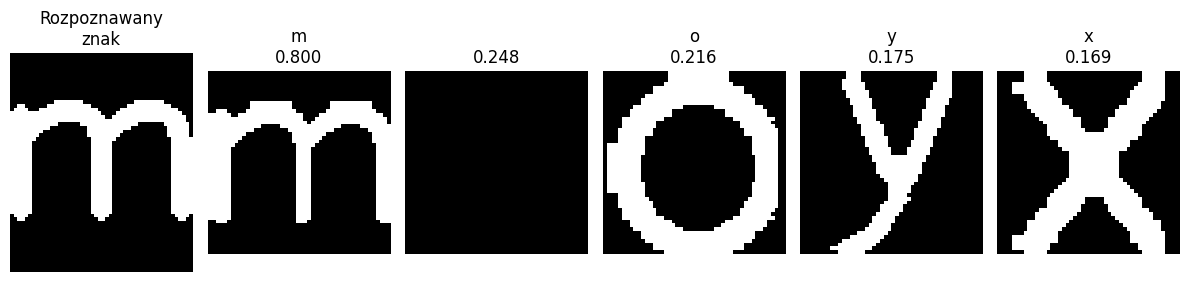

Najlepsze dopasowania: [('m', np.float64(0.8003003003003003)), (' ', np.float64(0.2478298611111111)), ('o', np.float64(0.216)), ('y', np.float64(0.175)), ('x', np.float64(0.16869424168694241))]
Znak 3: 'm' (pewność: 0.800)


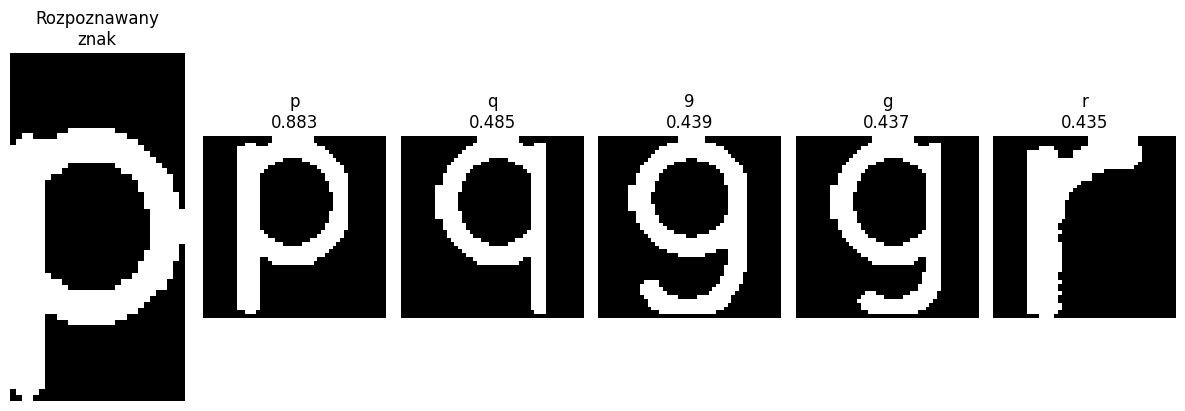

Najlepsze dopasowania: [('p', np.float64(0.8825503355704698)), ('q', np.float64(0.48450704225352115)), ('9', np.float64(0.4387254901960784)), ('g', np.float64(0.4371029224904701)), ('r', np.float64(0.43483870967741933))]
Znak 4: 'p' (pewność: 0.883)


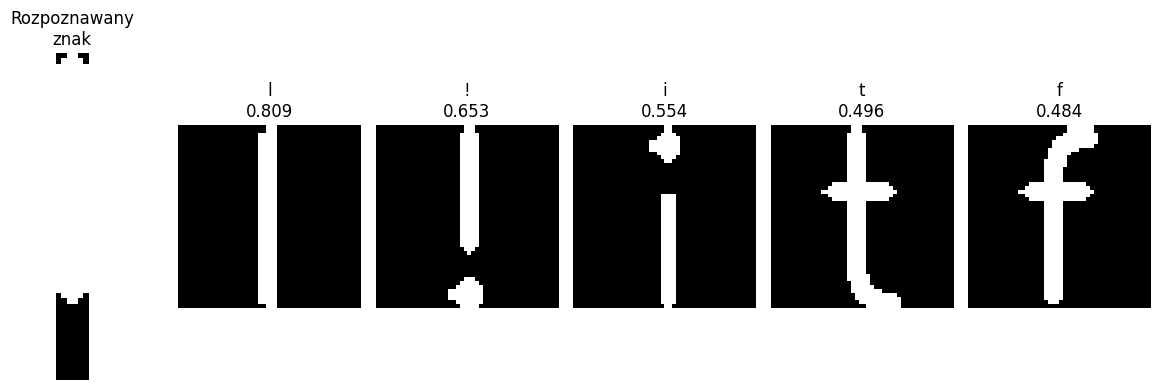

Najlepsze dopasowania: [('l', np.float64(0.8086642599277978)), ('!', np.float64(0.6529209621993127)), ('i', np.float64(0.5535714285714286)), ('t', np.float64(0.4962025316455696)), ('f', np.float64(0.48370927318295737))]
Znak 5: 'l' (pewność: 0.809)


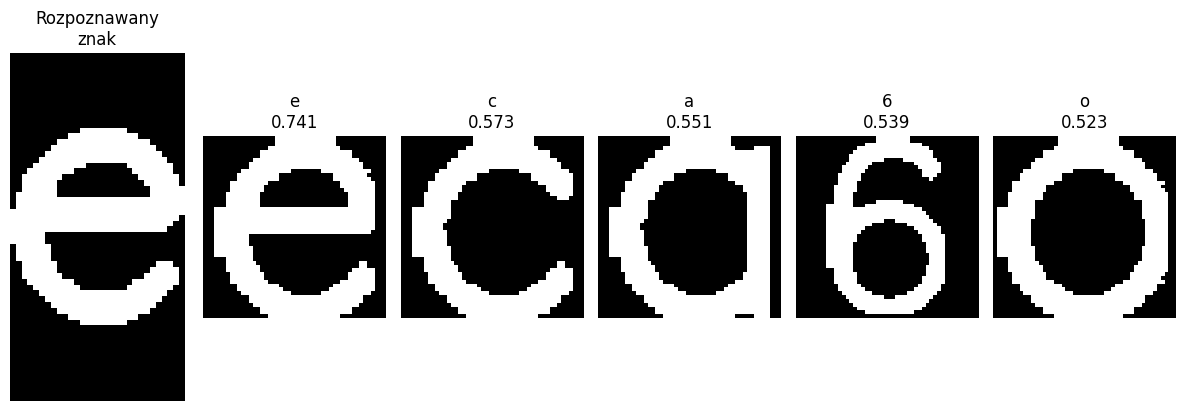

Najlepsze dopasowania: [('e', np.float64(0.740673339399454)), ('c', np.float64(0.5729166666666666)), ('a', np.float64(0.5506382978723404)), ('6', np.float64(0.538928210313448)), ('o', np.float64(0.5228040540540541))]
Znak 6: 'e' (pewność: 0.741)


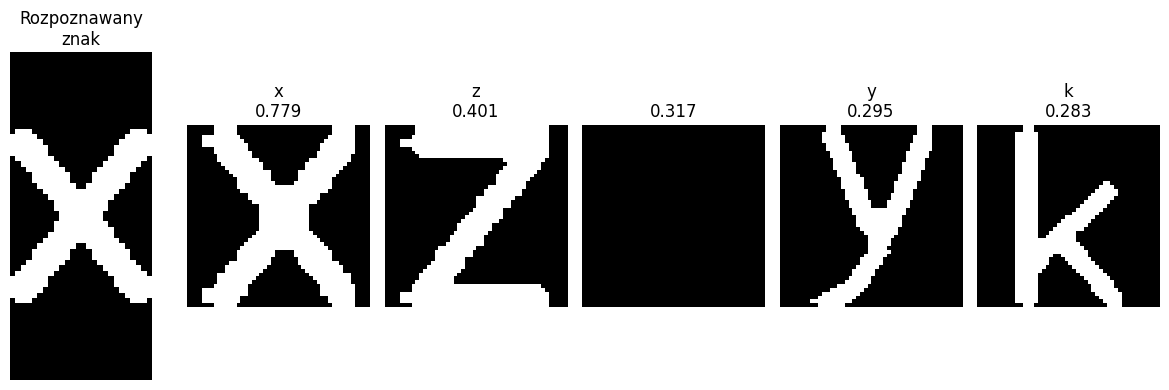

Najlepsze dopasowania: [('x', np.float64(0.7788888888888889)), ('z', np.float64(0.4008810572687225)), (' ', np.float64(0.3172743055555556)), ('y', np.float64(0.2950108459869848)), ('k', np.float64(0.28280773143438453))]
Znak 7: 'x' (pewność: 0.779)
Znak 8: ' ' (spacja wykryta)


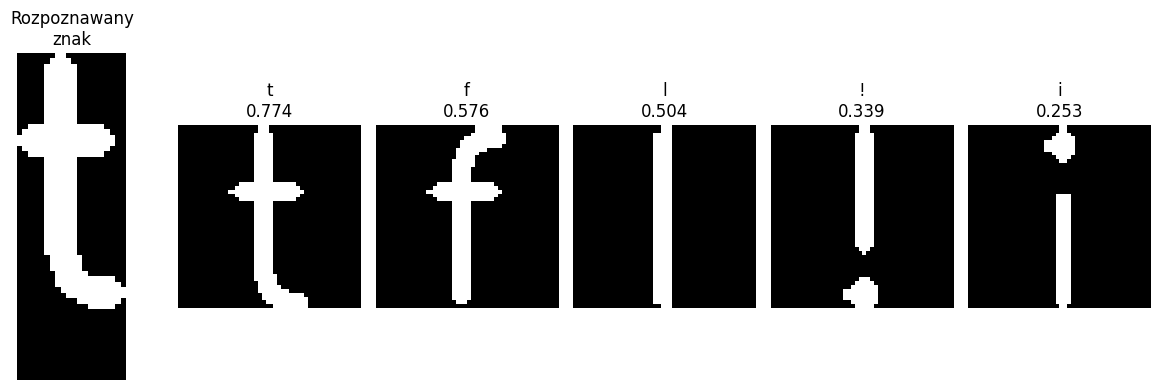

Najlepsze dopasowania: [('t', np.float64(0.7739130434782608)), ('f', np.float64(0.5758354755784062)), ('l', np.float64(0.5043227665706052)), ('!', np.float64(0.33866666666666667)), ('i', np.float64(0.25274725274725274))]
Znak 9: 't' (pewność: 0.774)


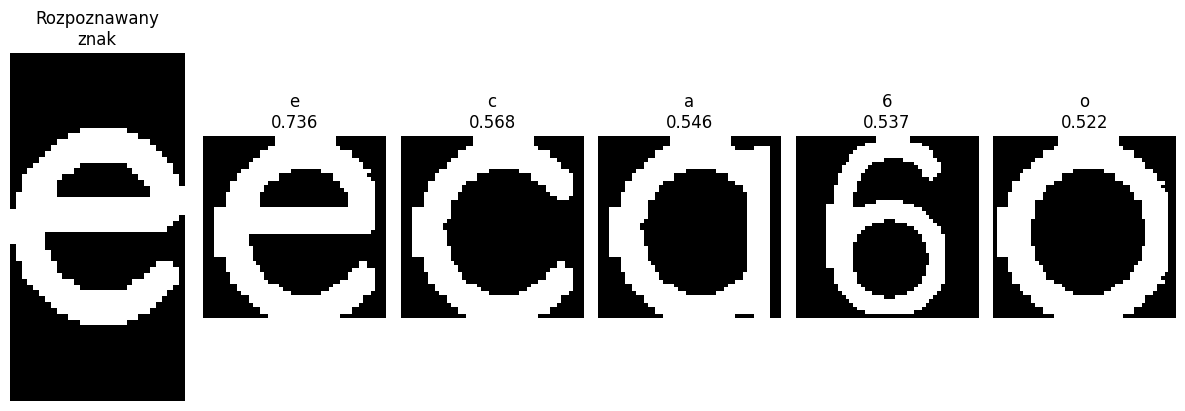

Najlepsze dopasowania: [('e', np.float64(0.7361237488626023)), ('c', np.float64(0.5681818181818182)), ('a', np.float64(0.5463829787234042)), ('6', np.float64(0.5369807497467072)), ('o', np.float64(0.5224386113463166))]
Znak 10: 'e' (pewność: 0.736)


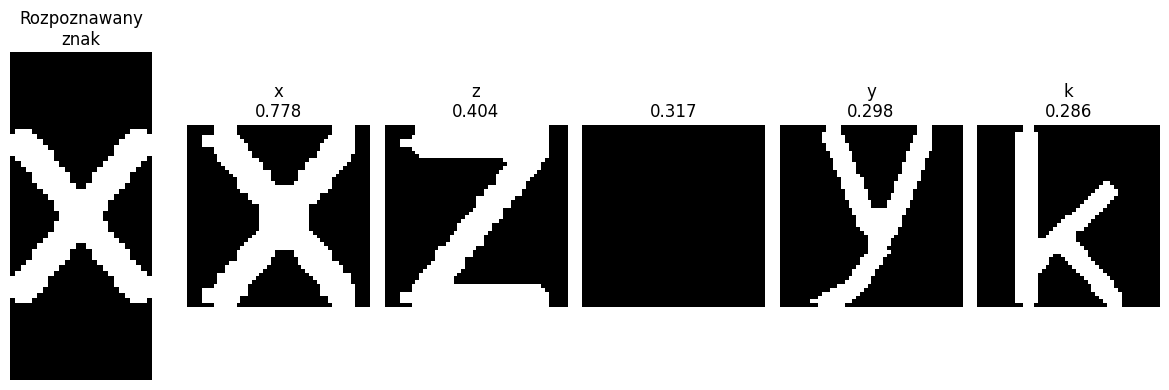

Najlepsze dopasowania: [('x', np.float64(0.7777777777777778)), ('z', np.float64(0.4037102473498233)), (' ', np.float64(0.3168402777777778)), ('y', np.float64(0.2981501632208923)), ('k', np.float64(0.2857142857142857))]
Znak 11: 'x' (pewność: 0.778)


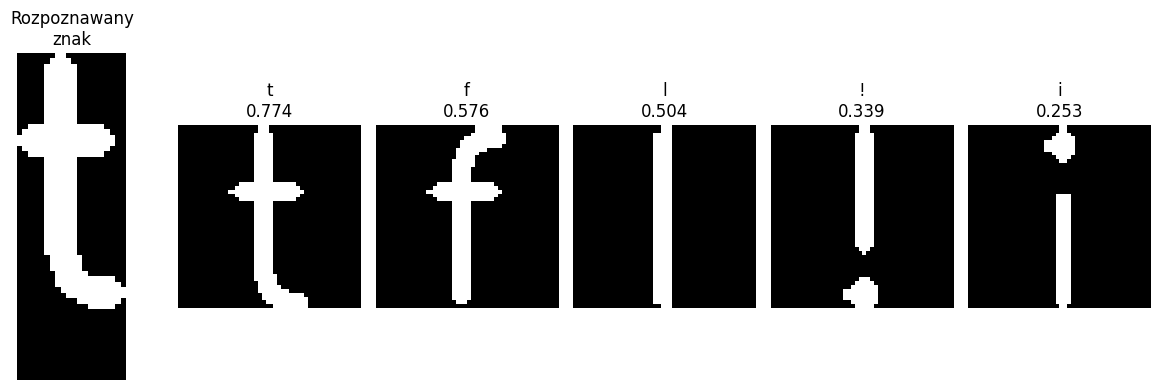

Najlepsze dopasowania: [('t', np.float64(0.7739130434782608)), ('f', np.float64(0.5758354755784062)), ('l', np.float64(0.5043227665706052)), ('!', np.float64(0.33866666666666667)), ('i', np.float64(0.25274725274725274))]
Znak 12: 't' (pewność: 0.774)
Rozpoznana linia: 'complex text'

=== PODSUMOWANIE ===
Wykryty kąt nachylenia tekstu: -4.98°
Kąt korekcji zastosowany: -4.98°
Obraz skorygowany: TAK
Rozpoznany tekst: '
rotation ocr
069test?!
complex text'


In [28]:
templates = generate_character_templates(font_size=60)
    
test_text = "rotation ocr\n069test?!\ncomplex text"
rotated_image = generate_rotated_test_image(test_text, rotation_angle=5)
    
result = ocr_with_rotation_correction(rotated_image, templates, show_all_steps=True)

OCR dla obróconcyh obrazów również działa z 100% skutecznością